## Environment Setup

In [1]:
# To verify if the notebook is connected to gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 24 21:52:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# To get requirements.txt from github repository
!wget https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt

--2024-08-24 21:52:07--  https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     124  --.-KB/s    in 0s      

2024-08-24 21:52:08 (2.27 MB/s) - ‘requirements.txt’ saved [124/124]



In [3]:
# Install all libraries from requirements.txt
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nv

## Data Ingestion

In [4]:
import pandas as pd
# Class to load external files
class DataLoader:
    def __init__(self, url):
        self.url = url
        self.dataframe = None

    def load_data(self):
        """Load data from the URL into a Pandas DataFrame."""
        self.dataframe = pd.read_csv(self.url)
        return self.dataframe

In [5]:
# load data from external file
dataset_url = 'https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/data_files/dataset.csv'
data_loader = DataLoader(dataset_url)
df_raw = data_loader.load_data()

In [6]:
df_raw.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [7]:
df_raw.dtypes

,0
step,int64
customer,object
age,object
gender,object
zipcodeOri,object
merchant,object
zipMerchant,object
category,object
amount,float64
fraud,int64


## Data Pre-processing

In [8]:
import numpy as np
class DataPreprocessor:
    @staticmethod
    def preprocess(dataframe):
        """Preprocess the DataFrame by stripping single quotes from string values."""
        return dataframe.map(lambda x: x.strip("'") if isinstance(x, str) else x)

    @staticmethod
    def rename_columns(dataframe):
        """Rename columns of the DataFrame according to specified mappings. This is done as raw dataset has additional characters beside values"""
        renamed_columns = {
            'step': 'timeStep',
            'customer': 'customerId',
            'age': 'customerAge',
            'gender': 'customerGender',
            'zipcodeOri': 'originZipCode',
            'merchant': 'merchantName',
            'zipMerchant': 'merchantZipCode',
            'category': 'merchantCategory',
            'amount': 'amount',
            'fraud': 'isFraud'
        }
        return dataframe.rename(columns=renamed_columns)

    @staticmethod
    def preprocess_gender(dataframe):
        """
        Preprocess the 'customerGender' column by standardizing values and handling unknowns.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with the preprocessed 'customerGender' column.
        """
        dataframe['customerGender'] = dataframe['customerGender'].replace({'E': np.nan, 'U': np.nan})
        return dataframe

    @staticmethod
    def convert_to_category_codes(df, column_name):
        """
        Convert a categorical columns category codes.

        Returns:
        pd.DataFrame: The DataFrame with the categorical column converted to category codes.
        """
        df[column_name] = df[column_name].astype('category').cat.codes
        return df

    @staticmethod
    def filter_records_with_unidentified_data(df, column_name):
        """
        Filters out rows where 'customerAge' is 'U'.

        Returns:
        pd.DataFrame: A DataFrame with rows where 'customerAge' is not 'U'.
        """
        filtered_df = df[df[column_name] != 'U']

        return filtered_df

    @staticmethod
    def process_columns(df):
        """
        Remove the first letter from 'customerId' and 'merchantName' columns,
        convert these columns to integers, and drop 'originZipCode' and
        'merchantZipCode' columns if they exist.

        Parameters:
        df (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with 'customerId' and 'merchantName' columns processed,
                      and 'originZipCode' and 'merchantZipCode' columns removed.
        """
        # Remove the first letter and convert to integer for 'customerId'
        df['customerId'] = df['customerId'].str[1:].astype(int)

        # Remove the first letter and convert to integer for 'merchantName'
        df['merchantName'] = df['merchantName'].str[1:].astype(int)

        # Drop 'originZipCode' and 'merchantZipCode' columns if they exist
        columns_to_remove = ['originZipCode', 'merchantZipCode']
        df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

        return df



In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class CatergoricalEncoder:
    @staticmethod
    def encode_gender(dataframe):
        """
        Encode the 'customerGender' column using label encoding.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with the label encoded 'customerGender' column,
                      including original and encoded columns.
        """

        # Initialize the label encoder
        label_encoder = LabelEncoder()

        # Fit and transform the 'customerGender' column
        dataframe['encoded_gender'] = label_encoder.fit_transform(dataframe['customerGender'].astype(str))

        return dataframe

    @staticmethod
    def encode_merchant_category(dataframe):
        """
        Encode the 'merchantCategory' column using label encoding.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        pd.DataFrame: The DataFrame with the label encoded 'merchantCategory' column,
                      including original and encoded columns.
        """
        # Initialize the label encoder
        label_encoder = LabelEncoder()

        # Fit and transform the 'merchantCategory' column
        dataframe['encoded_category'] = label_encoder.fit_transform(dataframe['merchantCategory'].astype(str))

        return dataframe


In [10]:
# Preprocessing the dataset
data_preprocessor = DataPreprocessor()
df_processed = data_preprocessor.preprocess(df_raw)
df_processed = data_preprocessor.rename_columns(df_processed)
df_processed = data_preprocessor.preprocess_gender(df_processed)
df_processed = data_preprocessor.filter_records_with_unidentified_data(df_processed, 'customerAge')
df_processed = data_preprocessor.process_columns(df_processed)

In [11]:
# Encode the 'customerGender' column
df_processed = CatergoricalEncoder.encode_gender(df_processed)

# Encode the 'merchantCategory' column
df_processed = CatergoricalEncoder.encode_merchant_category(df_processed)


In [12]:
df_processed.tail(5)

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category
594638,179,1753498738,3,F,1823072687,es_transportation,20.53,0,0,12
594639,179,650108285,4,F,1823072687,es_transportation,50.73,0,0,12
594640,179,123623130,2,F,349281107,es_fashion,22.44,0,0,2
594641,179,1499363341,5,M,1823072687,es_transportation,14.46,0,1,12
594642,179,616528518,4,F,1823072687,es_transportation,26.93,0,0,12


In [21]:
df_processed.dtypes

,0
timeStep,int64
customerId,int64
customerAge,object
customerGender,object
merchantName,int64
merchantCategory,object
amount,float64
isFraud,category
encoded_gender,int64
encoded_category,int64


### Exploratory Data Analysis (EDA)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno

class EDA:
    def __init__(self, df):
        self.df = df

    def plot_imbalance(self, target_variable):
        """Plot the class imbalance for fraud variable."""
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        counts = self.df[target_variable].value_counts()

        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar', color=['blue', 'red'])
        plt.title(f'Imbalance of {target_variable}')
        plt.xlabel(f'{target_variable} (1) vs Not {target_variable} (0)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

    def plot_categorical_distribution(self, df, column):
        """
        Plot categorical distribution for a given column.

        Parameters:
        df (pd.DataFrame)
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    def plot_missing_values_bar(self, dataframe):
        """
        Plot missing values in the given DataFrame using a bar chart.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        msno.bar(dataframe)
        plt.title('Non-Missing Values Bar Chart')
        plt.xlabel('Columns')
        plt.ylabel('Count of Non-Missing Values')
        plt.show()

    def plot_customer_age_and_gender_distribution(self, dataframe, column):
        """
        Plot the distribution of customer age and gender using a histogram with KDE.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 4))
        sns.histplot(dataframe[column], bins=10, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Frequency')
        plt.show()

    def plot_amount_distribution(sef, dataframe):
        """
        Plot a scatter plot to see the distribution of the 'amount' column,
        marking fraud transactions in red (isFraud = 1).

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))

        # Scatter plot for non-fraudulent transactions (isFraud = 0)
        plt.scatter(dataframe[dataframe['isFraud'] == 0]['timeStep'],
                    dataframe[dataframe['isFraud'] == 0]['amount'],
                    alpha=0.5, c='blue', label='Non-Fraudulent')

        # Scatter plot for fraudulent transactions (isFraud = 1)
        plt.scatter(dataframe[dataframe['isFraud'] == 1]['timeStep'],
                    dataframe[dataframe['isFraud'] == 1]['amount'],
                    alpha=0.5, c='red', label='Fraudulent')

        # Plot styling
        plt.title('Distribution of Transaction Amounts Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Transaction Amount')
        plt.legend()

        plt.show()

    def plot_amount_boxplot(self,dataframe):
        """
        Plot a detailed and customized box plot to see the distribution of the 'amount' column.

        Parameters:
        dataframe (pd.DataFrame)

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Creating the box plot
        plt.figure(figsize=(12, 8))
        box_plot = sns.boxplot(
            y=dataframe['amount'],
            color='skyblue',
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'}
        )

        # Customizing the plot
        plt.title('Box Plot of Transaction Amounts', fontsize=16)
        plt.ylabel('Transaction Amount', fontsize=14)
        plt.xlabel('Transactions', fontsize=14)

        # Adding grid lines for better readability
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Annotating the plot with more details
        plt.annotate(
            'Outliers',
            xy=(0, dataframe['amount'].max()),
            xytext=(0, dataframe['amount'].max() + 10),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12
        )

        # Adding mean and median lines
        mean_value = dataframe['amount'].mean()
        median_value = dataframe['amount'].median()

        plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
        plt.axhline(median_value, color='blue', linestyle='-', linewidth=1.5, label=f'Median: {median_value:.2f}')

        plt.legend()

        # Showing the plot
        plt.show()

    def plot_fraud_percentage_by_age(self, df, age_column='customerAge'):
        """
        Creates a stacked bar plot to show the percentage of fraud and non-fraud transactions by customer age.

        Parameters:
        df (pd.DataFrame)
        age_column (str)
        """

        # Calculate the percentage of fraud and not fraud transactions by the specified age column
        age_fraud_summary = df.groupby([age_column, 'isFraud']).size().unstack(fill_value=0)
        age_fraud_summary_percentage = age_fraud_summary.div(age_fraud_summary.sum(axis=1), axis=0) * 100

        # Create the stacked bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        age_fraud_summary_percentage.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'red'])

        # Set labels and title
        ax.set_xlabel('Customer Age')
        ax.set_ylabel('Percentage of Transactions')
        ax.set_title('Percentage of Fraud and Not Fraud Transactions by Customer Age')
        ax.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'])

        # Show the plot
        plt.show()


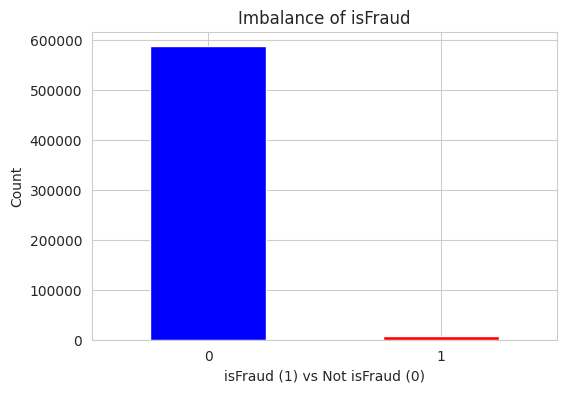

In [ ]:
# plot imabalnce of target variable
eda = EDA(df_processed)
eda.plot_imbalance('isFraud')

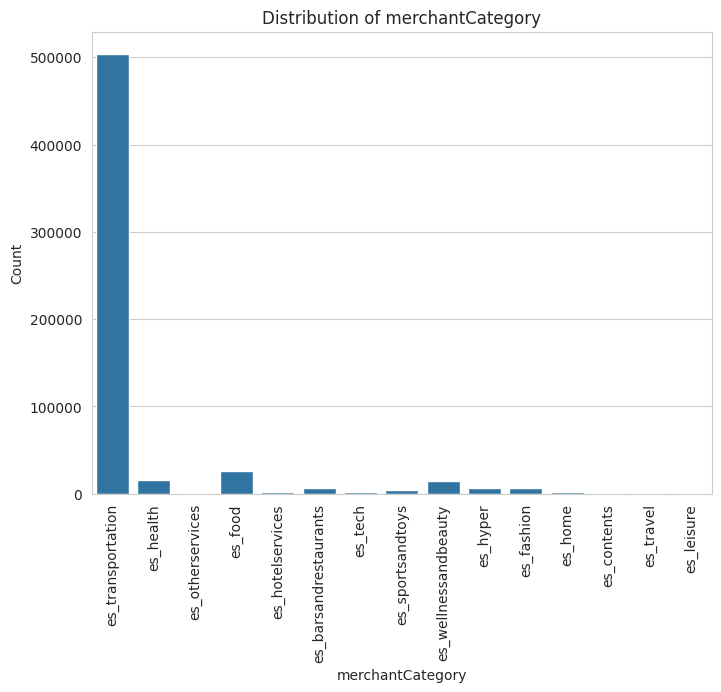

In [ ]:
#Plot categorical distribution for merchantCategory column
eda.plot_categorical_distribution(df_processed, 'merchantCategory')

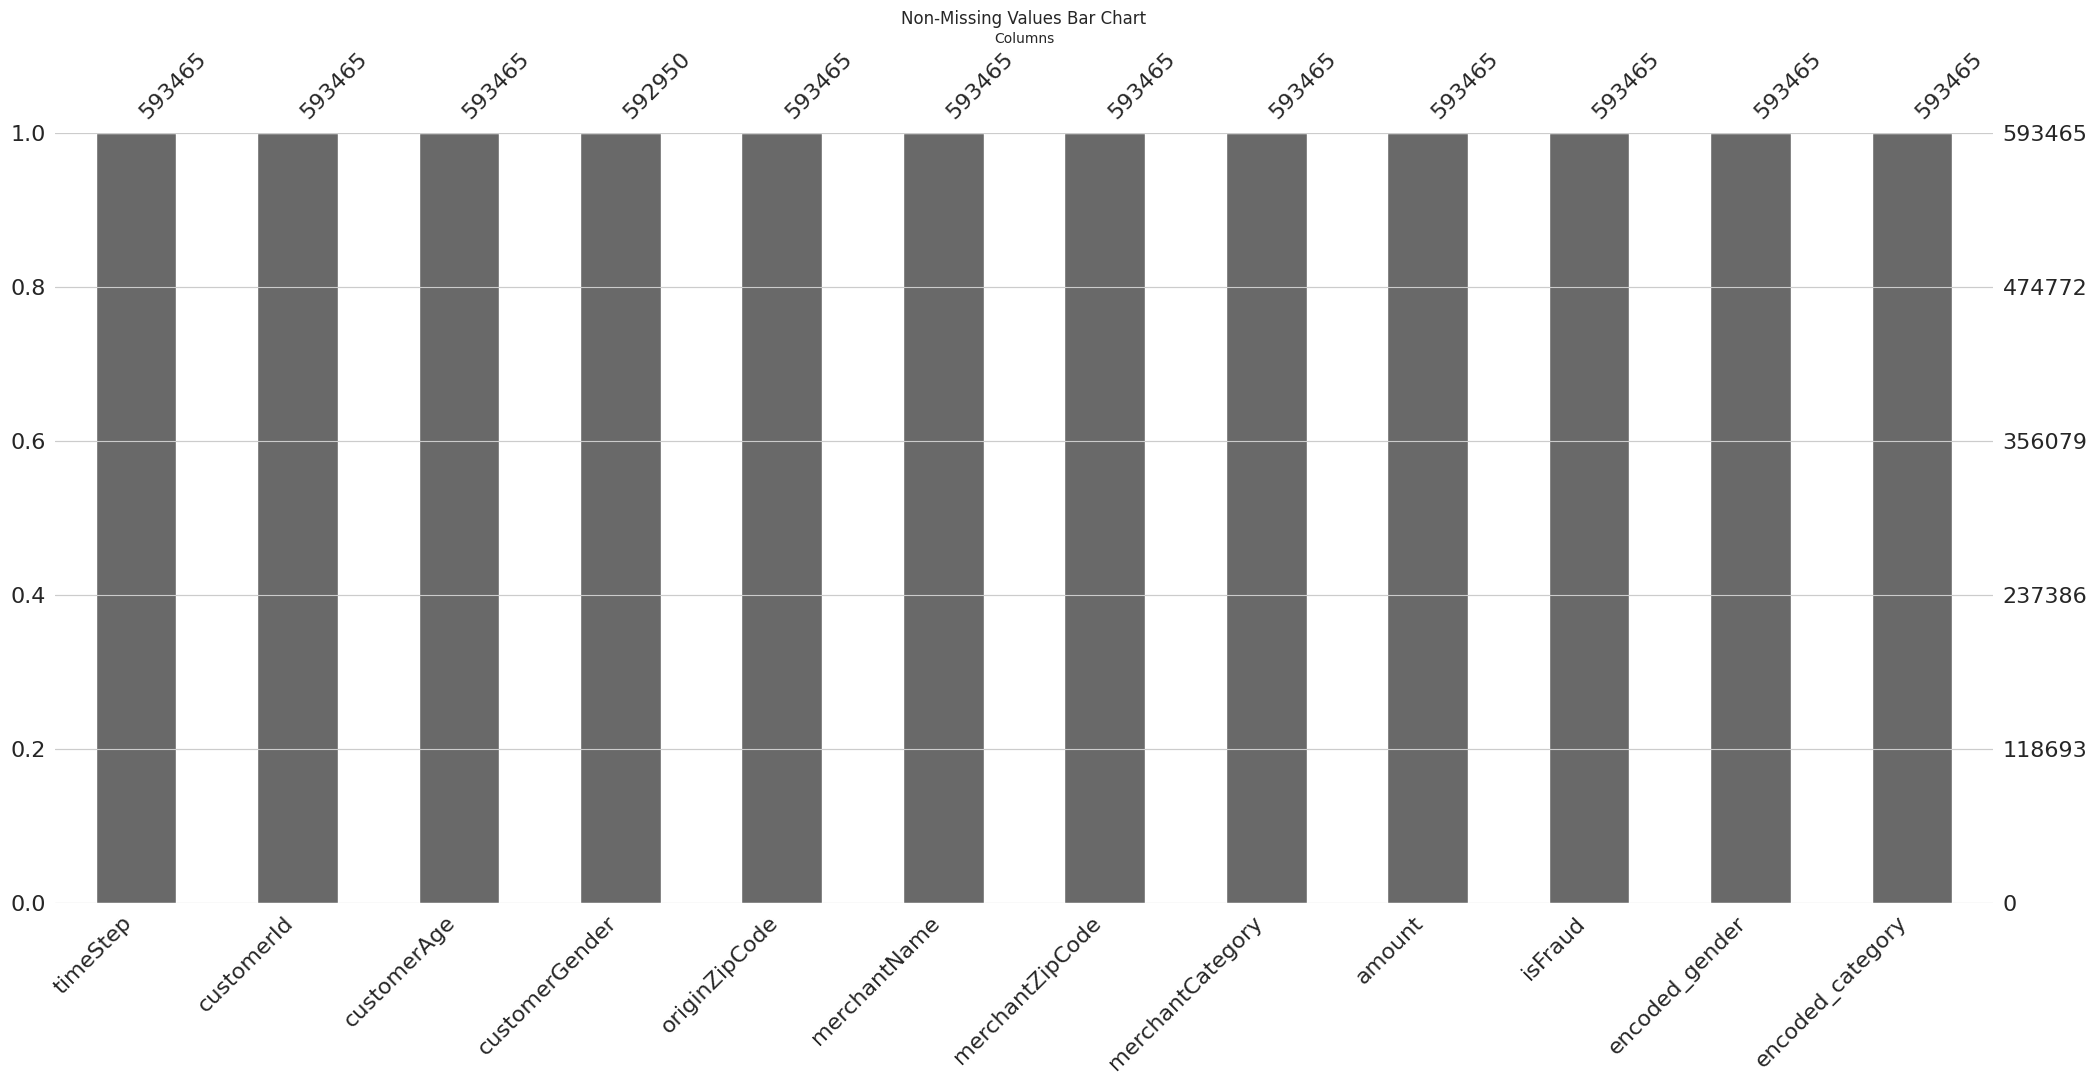

In [ ]:
# Plot non-missing values in the given DataFrame using a bar chart
eda.plot_missing_values_bar(df_processed)

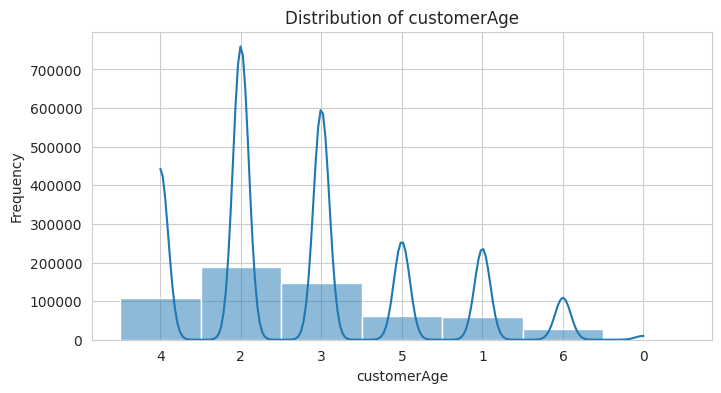

In [ ]:
#Plot the distribution of customer age
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerAge')

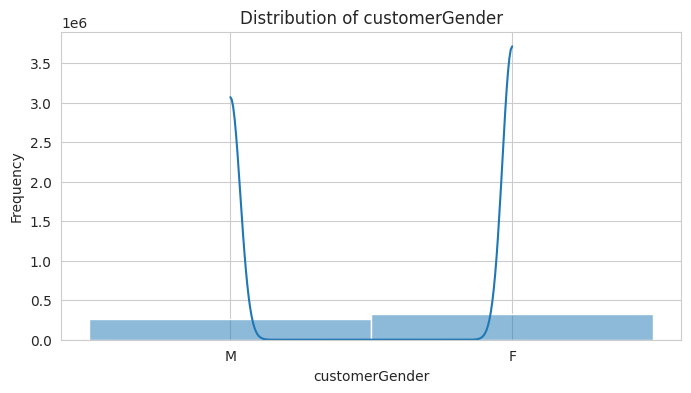

In [ ]:
#Plot the distribution of customer gender
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerGender')

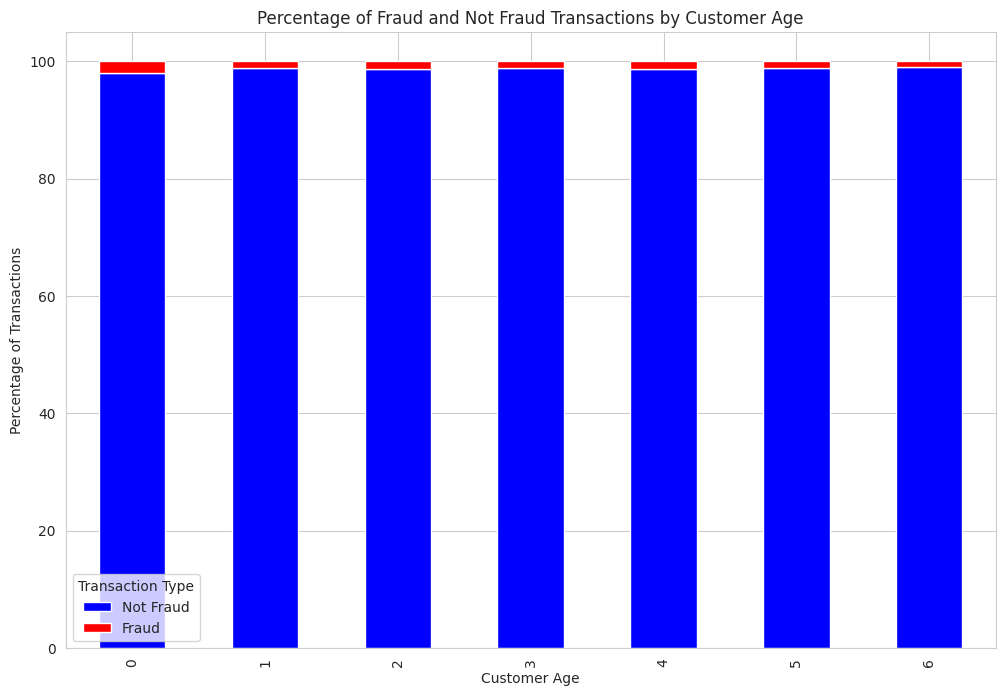

In [ ]:
eda.plot_fraud_percentage_by_age(df_processed, age_column='customerAge')

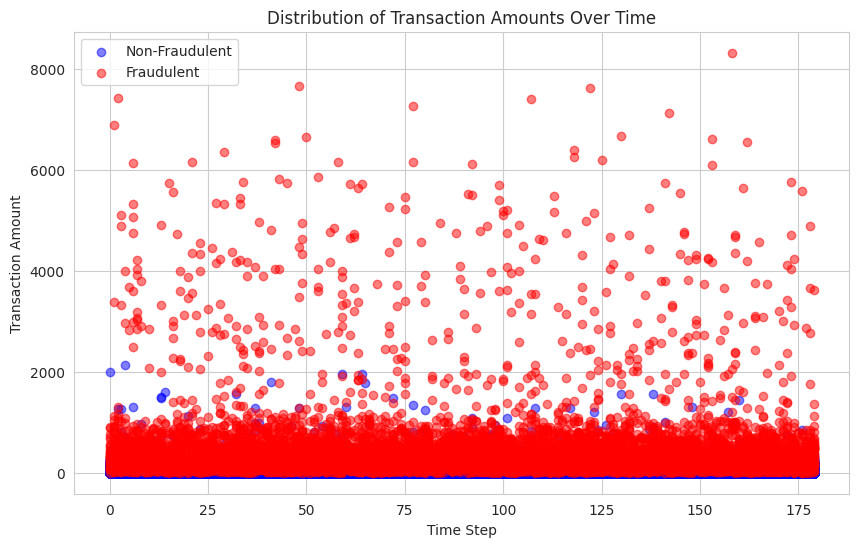

In [ ]:
eda.plot_amount_distribution(df_processed)

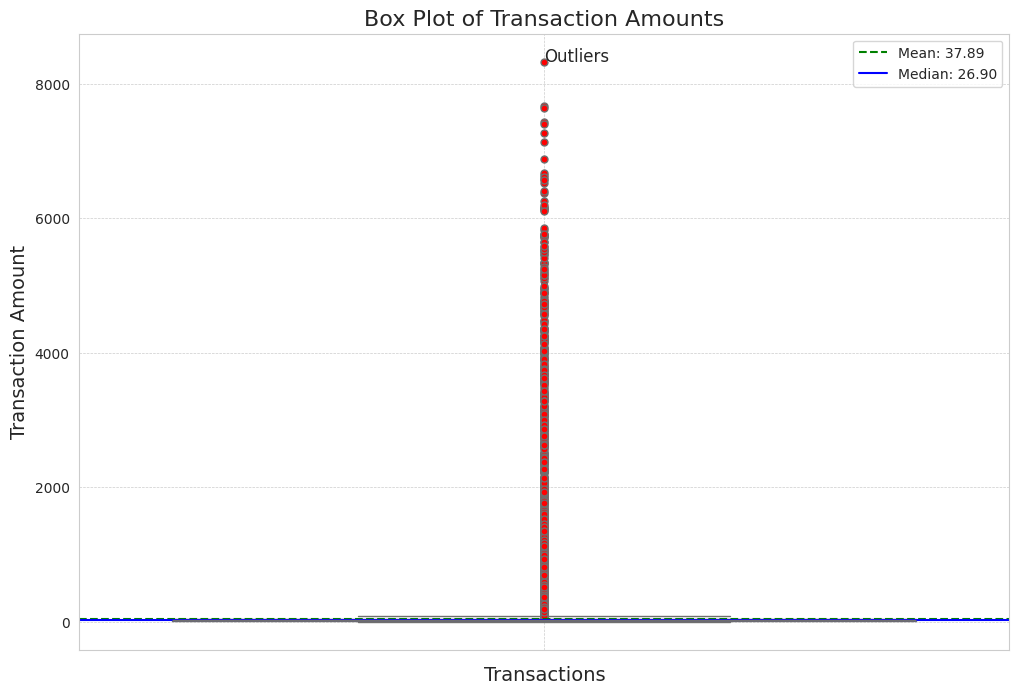

In [ ]:
eda.plot_amount_boxplot(df_processed)

EDA for fraudlent transactions

In [ ]:
df_fraud_trx = df_processed[df_processed['isFraud'] == 1]

In [ ]:
edaFraud = EDA(df_fraud_trx)

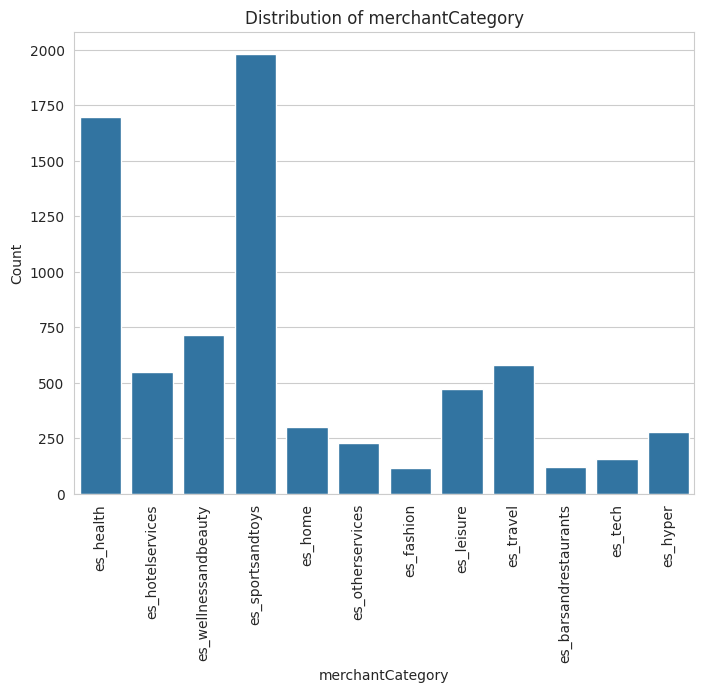

In [ ]:
#Plot categorical distribution for merchantCategory column
edaFraud.plot_categorical_distribution(df_fraud_trx, 'merchantCategory')

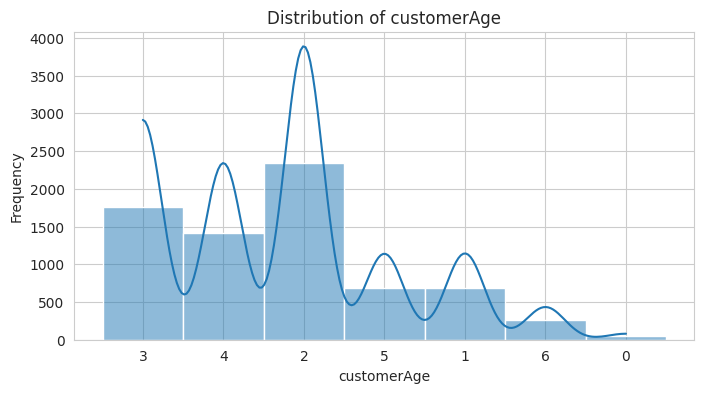

In [ ]:
#Plot the distribution of customer age
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerAge')

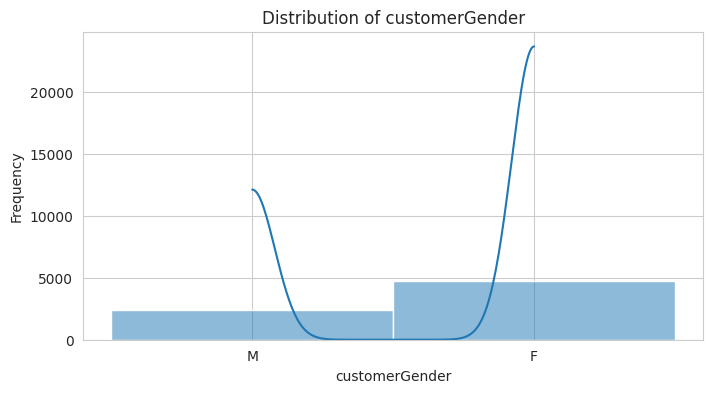

In [ ]:
#Plot the distribution of customer gender
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerGender')

### Relationships

In [24]:
def plot_filtered_pairplot(df, num_vars, hue_column, palette='viridis', title='Pair Plot'):
    """
    Generate a pair plot for specified numerical variables in the DataFrame.

    Returns:
    None: Displays the pair plot.
    """
    # Convert customerAge to numeric
    df['customerAge'] = pd.to_numeric(df['customerAge'], errors='coerce')

    # Ensure hue_column is categorical
    if not pd.api.types.is_categorical_dtype(df[hue_column]):
        df[hue_column] = df[hue_column].astype('category')

    # Filter DataFrame to include only numerical variables and hue column
    df_filtered = df[num_vars + [hue_column]].dropna()

    # Create the pair plot
    pair_plot = sns.pairplot(df_filtered, vars=num_vars, hue=hue_column, palette=palette)

    # Set the title of the plot
    pair_plot.fig.suptitle(title, y=1.02)

    # Show the plot
    plt.show()

<ipython-input-24-b57e5a07001a>:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[hue_column]):


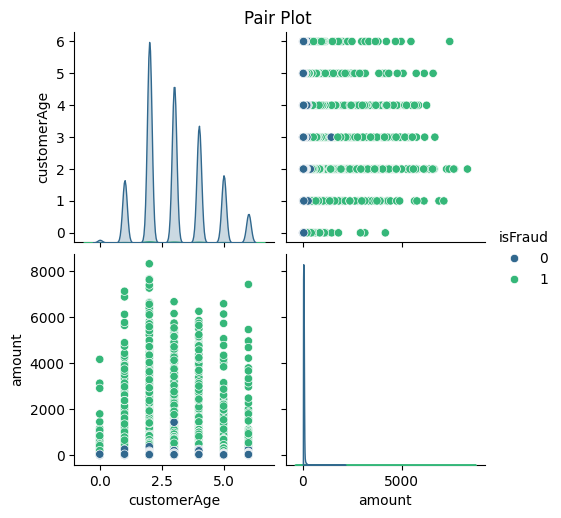

In [25]:
plot_filtered_pairplot(df_processed, num_vars=['customerAge', 'amount'], hue_column='isFraud')

In [26]:
def plot_correlation_heatmap(df, exclude_columns, target_column):
    """
    Create a correlation heatmap for numerical columns in the DataFrame, excluding specified columns.

    Parameters:
    df (pd.DataFrame)
    exclude_columns (list): List of columns to exclude from the correlation calculation (as these are categorical, however these are represented by encoded gender and category columns).
    target_column (str)

    Returns:
    None: Displays the correlation heatmap.
    """
    # Drop excluded columns
    df_filtered = df.drop(columns=exclude_columns)

    # Ensure target_column is categorical
    if not pd.api.types.is_categorical_dtype(df[target_column]):
        df[target_column] = df[target_column].astype('category')

    # Convert categorical target_column to numerical for correlation calculation
    df_filtered[target_column] = df_filtered[target_column].cat.codes

    # Compute the correlation matrix
    correlation_matrix = df_filtered.corr()

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()


<ipython-input-26-8c92e775df46>:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[target_column]):


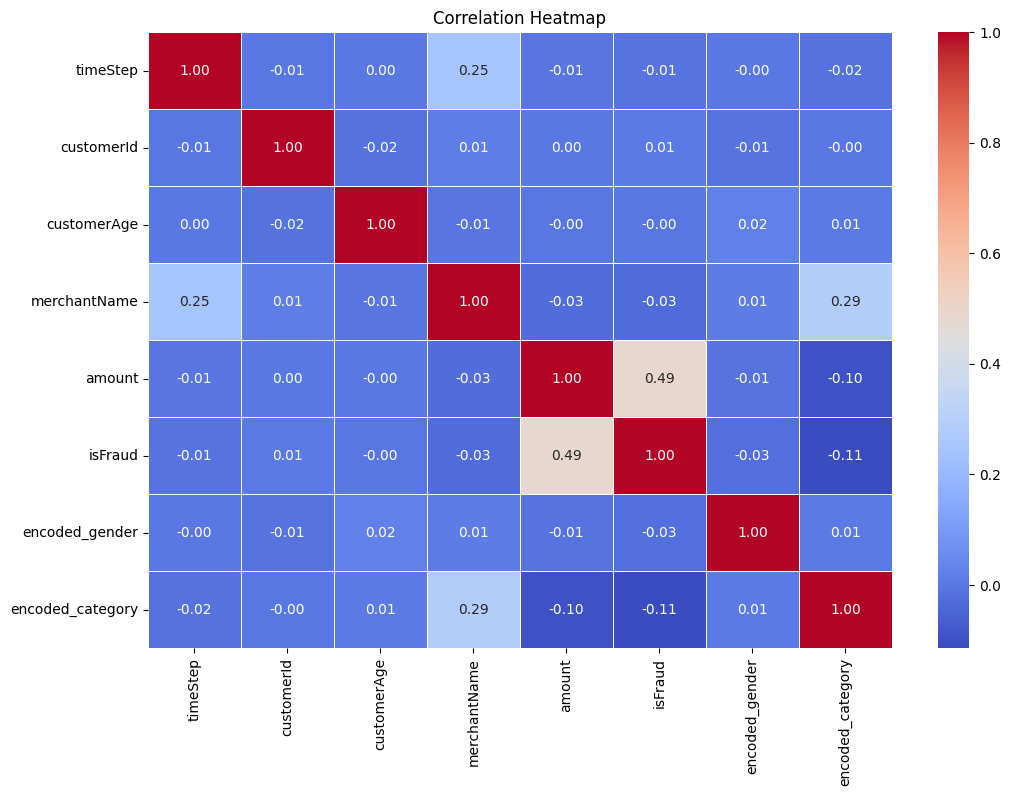

In [27]:
exclude_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'
plot_correlation_heatmap(df_processed, exclude_columns, target_column)

### More pre-processing to handle categorical values

In [14]:
df_processed_rag = df_processed.copy()

## Feature Engineering

In [15]:
def process_transactions(df):
    """
    Adds 'IslargeTransaction' and 'countForCustomerSameTime' columns to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame

    Returns:
    pd.DataFrame: DataFrame with the new columns added.
    """
    # Add 'IslargeTransaction' column based on the condition
    df['IslargeTransaction'] = df['amount'].apply(lambda x: 1 if x >= 5000 else 0)

    # Calculate the count of transactions for each customer at each time step
    df['countForCustomerSameTime'] = df.groupby(['timeStep', 'customerId'])['customerId'].transform('count')

    return df

def add_avg_transaction_amount(df, customer_id_col='customerId', amount_col='amount'):
    """
    Adds a new column to the DataFrame that contains the average transaction amount
    for each customerId.

    Parameters:
    df (pd.DataFrame): DataFrame
    customer_id_col (str)
    amount_col (str)

    Returns:
    pd.DataFrame: The DataFrame with an added column 'avgTransactionAmount'.
    """
    # Calculate the average transaction amount for each customerId
    avg_transaction_amount = df.groupby(customer_id_col)[amount_col].mean()

    # Map the average transaction amount back to the original DataFrame
    df['avgTransactionAmount'] = df[customer_id_col].map(avg_transaction_amount)

    return df

In [16]:
# Apply the function to process the DataFrame
df_processed = process_transactions(df_processed)
df_processed_rag = process_transactions(df_processed_rag)

In [17]:
df_processed = add_avg_transaction_amount(df_processed)
df_processed_rag = add_avg_transaction_amount(df_processed_rag)


In [18]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,1093826151,4,M,348934600,es_transportation,4.55,0,1,12,0,1,28.240719
1,0,352968107,2,M,348934600,es_transportation,39.68,0,1,12,0,1,32.661361
2,0,2054744914,4,F,1823072687,es_transportation,26.89,0,0,12,0,1,41.443692
3,0,1760612790,3,M,348934600,es_transportation,17.25,0,1,12,0,1,30.338772
4,0,757503768,5,M,348934600,es_transportation,35.72,0,1,12,0,1,31.696759


# Baseline models for Fraud Detection

In [19]:
df_processed.dtypes

,0
timeStep,int64
customerId,int64
customerAge,object
customerGender,object
merchantName,int64
merchantCategory,object
amount,float64
isFraud,int64
encoded_gender,int64
encoded_category,int64


## Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

def train_random_forest(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=10, random_state=42):
    """
    Trains a Random Forest classifier and evaluates its performance.

    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


**Experiment 1: RandomForest without oversampling**

In [37]:
# Columns to encode
categorical_columns = ['customerId', 'merchantName', 'customerAge', 'merchantCategory', 'customerGender']

# Call the function to train the Random Forest classifier
train_random_forest(df_processed, categorical_columns)

Accuracy: 0.9962255757681965
Confusion Matrix:
 [[146489    163]
 [   397   1318]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    146652
           1       0.89      0.77      0.82      1715

    accuracy                           1.00    148367
   macro avg       0.94      0.88      0.91    148367
weighted avg       1.00      1.00      1.00    148367



### Addressing Dataset Imbalance

### SMOTE - (Synthetic Minority Over-sampling Technique)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class SmoteOverSampling:
    def __init__(self, dataframe, target_column, test_size=0.2, random_state=42):
        """
        Initialize the SmoteOverSampling with the given parameters.

        """
        self.dataframe = dataframe
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state

    def encode_categorical(self):
        """
        Encode categorical features using integer encoding.
        """
        label_encoders = {}
        for column in self.dataframe.select_dtypes(include=['object']).columns:
            label_encoders[column] = LabelEncoder()
            self.dataframe[column] = label_encoders[column].fit_transform(self.dataframe[column])
        self.label_encoders = label_encoders

    def apply_smote(self):
        """
        Apply SMOTE to balance the dataset.
        """
        X = self.dataframe.drop(self.target_column, axis=1)
        y = self.dataframe[self.target_column]

        smote = SMOTE(random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        self.X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        self.y_resampled = pd.Series(y_resampled, name=self.target_column)

        # Create DataFrame for the original and synthetic samples
        self.df_processed_os = self.X_resampled.copy()
        self.df_processed_os[self.target_column] = self.y_resampled

    def scale_features(self):
        """
        Scale the features using StandardScaler.
        """
        scaler = StandardScaler()
        self.X_resampled_scaled = scaler.fit_transform(self.X_resampled)

    def split_data(self):
        """
        Split the data into training and testing sets.
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_resampled_scaled, self.y_resampled,
            test_size=self.test_size, random_state=self.random_state
        )
        return X_train, X_test, y_train, y_test

In [23]:
# Initialize the preprocessor
preprocessor = SmoteOverSampling(df_processed, target_column='isFraud')

# Encode categorical features
preprocessor.encode_categorical()

# Apply SMOTE to balance the dataset
preprocessor.apply_smote()


df_processed_os = preprocessor.df_processed_os

preprocessor.scale_features()
X_train, X_test, y_train, y_test = preprocessor.split_data()

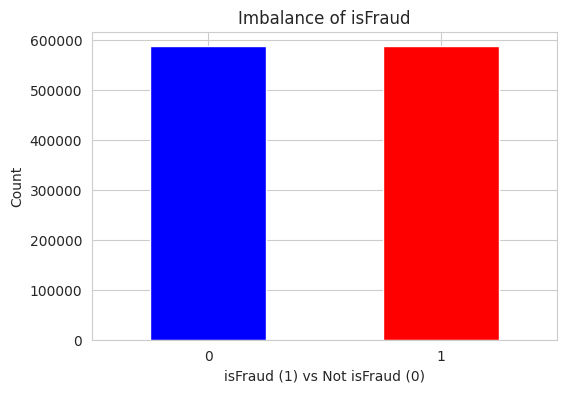

In [24]:
# plot imabalnce of target variable after SMOTE
eda = EDA(df_processed_os)
eda.plot_imbalance('isFraud')

**Experiment 2: RandomForest with oversampled data (SMOTE) and optimization**

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_random_forest(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42):
    """
    Trains a Random Forest classifier and evaluates its performance with optimized hyperparameters.


    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Optional: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier with additional hyperparameters
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Feature importances
    feature_importances = pd.DataFrame(rf_clf.feature_importances_,
                                       index=[f'Feature_{i}' for i in range(X.shape[1])],
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print("\nFeature Importances:\n", feature_importances)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y=feature_importances.index, data=feature_importances, palette='viridis')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

Accuracy: 0.9963940687485958
Confusion Matrix:
 [[175849    108]
 [   534   1549]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    175957
           1       0.93      0.74      0.83      2083

    accuracy                           1.00    178040
   macro avg       0.97      0.87      0.91    178040
weighted avg       1.00      1.00      1.00    178040


Feature Importances:
             Importance
Feature_6     0.571276
Feature_8     0.119346
Feature_4     0.118488
Feature_5     0.114249
Feature_10    0.036676
Feature_0     0.015670
Feature_1     0.013507
Feature_2     0.004832
Feature_9     0.002202
Feature_7     0.001918
Feature_3     0.001835


<ipython-input-54-0d4830b1d233>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y=feature_importances.index, data=feature_importances, palette='viridis')


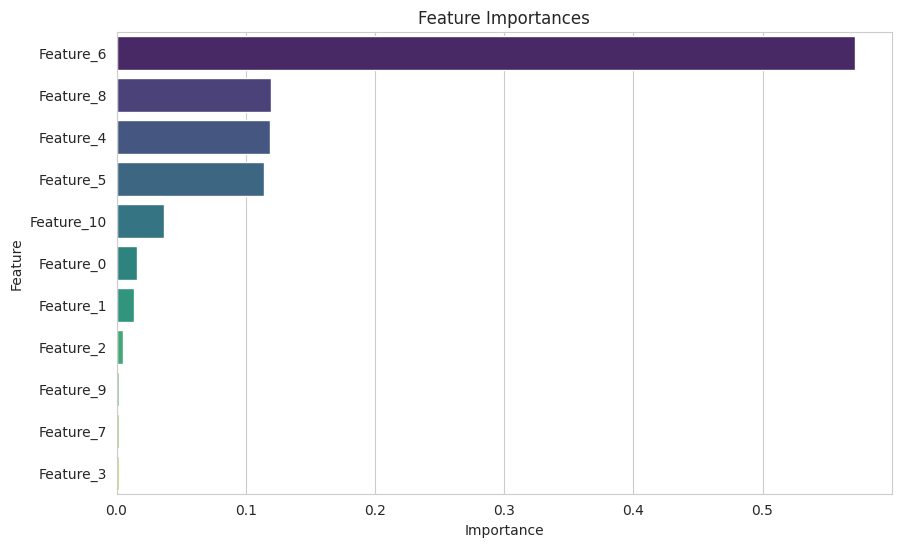

In [55]:
# List of categorical columns
categorical_columns = ['customerGender', 'merchantCategory']

# Call the train_random_forest function
train_random_forest(df_processed,
                    categorical_columns=categorical_columns,
                    target_column='isFraud',
                    test_size=0.3,
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    random_state=42)

In [56]:
def visualize_random_forest_tree(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42, tree_index=0):
    """
    Trains a Random Forest classifier and visualizes one of the trees in the forest.

    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Optional: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier with additional hyperparameters
    rf_clf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Extract one tree from the forest
    tree_clf = rf_clf.estimators_[tree_index]

    # Visualize the tree
    dot_data = export_graphviz(tree_clf, out_file=None,
                               feature_names=df.drop(columns=[target_column]).columns,
                               class_names=['Not Fraud', 'Fraud'],
                               filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(filename='random_forest_tree', format='png', cleanup=False)  # Save as PNG
    print("Tree visualized and saved as 'random_forest_tree.png'.")

    # Display the tree
    plt.figure(figsize=(20, 15))
    plt.imshow(plt.imread('random_forest_tree.png'))
    plt.axis('off')
    plt.show()

Tree visualized and saved as 'random_forest_tree.png'.


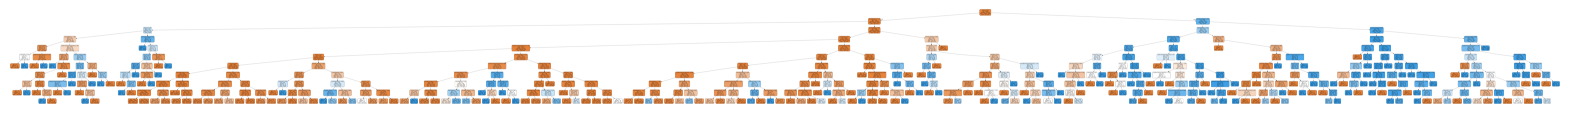

In [58]:
import graphviz
from sklearn.tree import export_graphviz

# List of categorical columns
categorical_columns = ['customerGender', 'merchantCategory']

# Call the function
visualize_random_forest_tree(df_processed,
                              categorical_columns=categorical_columns,
                              target_column='isFraud',
                              test_size=0.3,
                              n_estimators=100,
                              max_depth=10,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              random_state=42,
                              tree_index=0)

# Neural Network

### Experiment 3: on basic neural network model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

def create_nn_basic_model(input_dim):
    """
    Creates a neural network model.

    Parameters:
    input_dim

    Returns:
    model (Sequential): Compiled neural network model.
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_nn_basic(df, categorical_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Trains a neural network on the data and evaluates its performance.

    Returns:
    None
    """
    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the neural network model
    model = create_nn_model(input_dim=X_train.shape[1])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [29]:
# Specify categorical columns and target column
categorical_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'

# Call the function to train and evaluate the neural network
train_and_evaluate_nn_basic(df_processed, categorical_columns, target_column, test_size=0.25, random_state=42)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11128/11128 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9744 - loss: 385055.8750 - val_accuracy: 0.9879 - val_loss: 30996.5332
Epoch 2/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9744 - loss: 23848.4883 - val_accuracy: 0.9883 - val_loss: 243.1512
Epoch 3/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9862 - loss: 117.5103 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 4/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9875 - loss: 0.0673 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 5/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9876 - loss: 0.0668 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 6/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9879 - loss: 0.0655 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 7/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9876 - loss: 0.0666 - val_accuracy: 0.9879 - val_loss: 0.0654
Epoch 8/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Experiment 4:  on optimized neural network model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_nn_model(input_dim):
    """
    Creates a neural network model with dropout layers.

    Parameters:
    input_dim

    Returns:
    model (Sequential): Compiled neural network model.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Define the input shape using Input layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_nn(df, categorical_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Trains a neural network on the data and evaluates its performance.

    Returns:
    None
    """
    # Convert categorical target variable to numeric
    df[target_column] = LabelEncoder().fit_transform(df[target_column])

    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Optional: Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the neural network model
    model = create_nn_model(input_dim=X_train.shape[1])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot training & validation loss and accuracy
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

**Experiment 4.1 : For imbalanced dataset**

Epoch 1/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9796 - loss: 0.0635 - val_accuracy: 0.9939 - val_loss: 0.0204
Epoch 2/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9934 - loss: 0.0258 - val_accuracy: 0.9942 - val_loss: 0.0196
Epoch 3/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9936 - loss: 0.0232 - val_accuracy: 0.9944 - val_loss: 0.0192
Epoch 4/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9936 - loss: 0.0233 - val_accuracy: 0.9946 - val_loss: 0.0182
Epoch 5/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9936 - loss: 0.0225 - val_accuracy: 0.9946 - val_loss: 0.0180
Epoch 6/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9937 - loss: 0.0218 - val_accuracy: 0.9944 - val_loss: 0.0183
Epoch 7/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9936 - loss: 0.0220 - val_accuracy: 0.9945 - val_loss: 0.0178
Epoch 8/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 

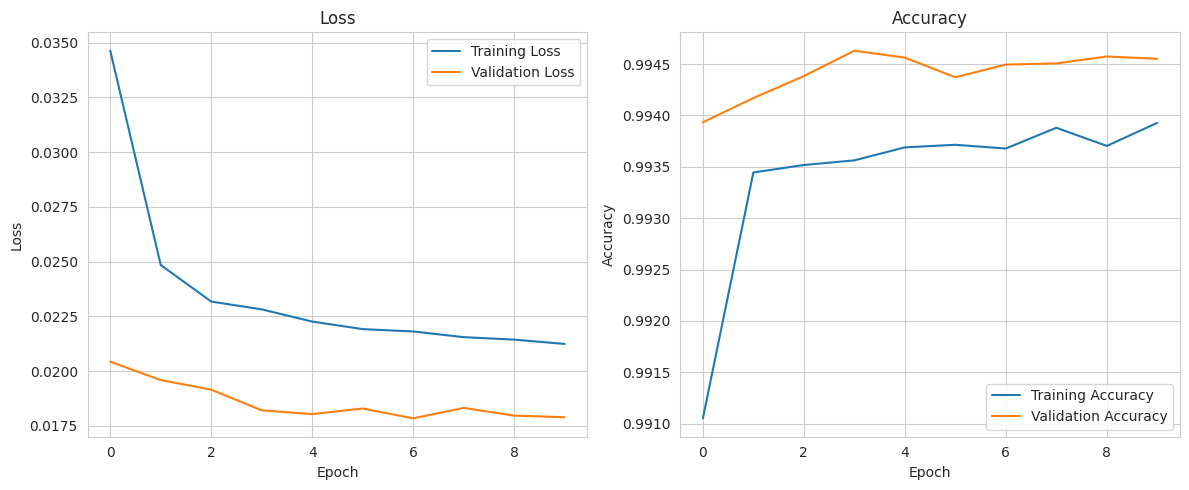

In [68]:
# Specify categorical columns and target column
categorical_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'

# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed, categorical_columns, target_column, test_size=0.25, random_state=42)

**Experiment 4.2 : For oversampled dataset**

Epoch 1/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9500 - loss: 0.1348 - val_accuracy: 0.9827 - val_loss: 0.0507
Epoch 2/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9778 - loss: 0.0681 - val_accuracy: 0.9837 - val_loss: 0.0478
Epoch 3/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 84s 2ms/step - accuracy: 0.9792 - loss: 0.0640 - val_accuracy: 0.9843 - val_loss: 0.0451
Epoch 4/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.9794 - loss: 0.0620 - val_accuracy: 0.9846 - val_loss: 0.0443
Epoch 5/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - accuracy: 0.9803 - loss: 0.0597 - val_accuracy: 0.9853 - val_loss: 0.0441
Epoch 6/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.9803 - loss: 0.0594 - val_accuracy: 0.9860 - val_loss: 0.0418
Epoch 7/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.9808 - loss: 0.0589 - val_accuracy: 0.9863 - val_loss: 0.0405
Epoch 8/10
21986/21986 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - accuracy: 

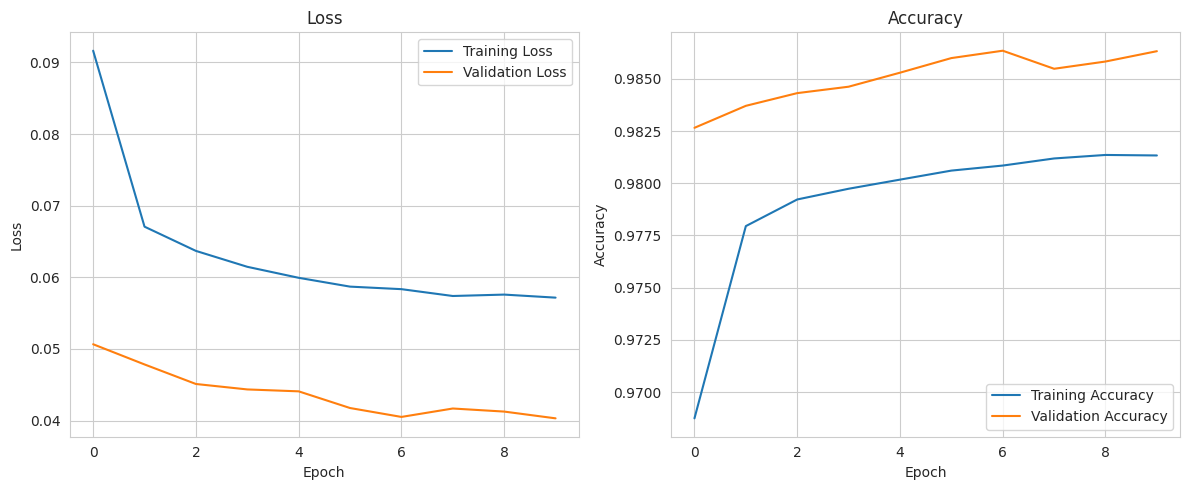

In [25]:
# Specify categorical columns and target column
categorical_columns = ['customerGender', 'merchantCategory']
target_column = 'isFraud'

# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed_os, categorical_columns, target_column, test_size=0.25, random_state=42)

# XGBOOST

In [ ]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,210,4,1,0,30,0,12,4.55,0,0,1,28.240719
1,0,2746,2,1,0,30,0,12,39.68,0,0,1,32.661361
2,0,2280,4,0,0,18,0,12,26.89,0,0,1,41.443692
3,0,1646,3,1,0,30,0,12,17.25,0,0,1,30.338772
4,0,3578,5,1,0,30,0,12,35.72,0,0,1,31.696759


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb

def preprocess_data(df):
    """
    Preprocess the data by splitting into features and target, and performing train-test split.
    :return: X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=['isFraud'])
    y = df['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test


def build_pipeline():
    """
    Build and return a machine learning pipeline with preprocessing and XGBoost classifier.
    :return: Pipeline
    """
    numeric_features = ['amount', 'customerAge', 'countForCustomerSameTime', 'timeStep', 'avgTransactionAmount']
    categorical_features = ['customerGender', 'merchantName', 'merchantCategory']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ])

    return pipeline


def plot_confusion_matrix(cm, labels):
    """
    Plot the confusion matrix.
    :param cm: Confusion matrix
    :param labels: List of class labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    """
    Train and evaluate the model.
    :param pipeline: Pipeline
    :param X_train: Training features
    :param X_test: Testing features
    :param y_train: Training target
    :param y_test: Testing target
    """
    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, labels=['Non-Fraud', 'Fraud'])


def main(df):
    """
    Main function to run the data processing, model training, and evaluation.
    """
    X_train, X_test, y_train, y_test = preprocess_data(df)
    pipeline = build_pipeline()
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)


**Experiment 5: XGBoost (Extreme Gradient Boosting)**

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:33:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9976
Test Accuracy: 0.9968
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146569
           1       0.91      0.82      0.86      1798

    accuracy                           1.00    148367
   macro avg       0.95      0.91      0.93    148367
weighted avg       1.00      1.00      1.00    148367

Confusion Matrix:
[[146414    155]
 [   317   1481]]


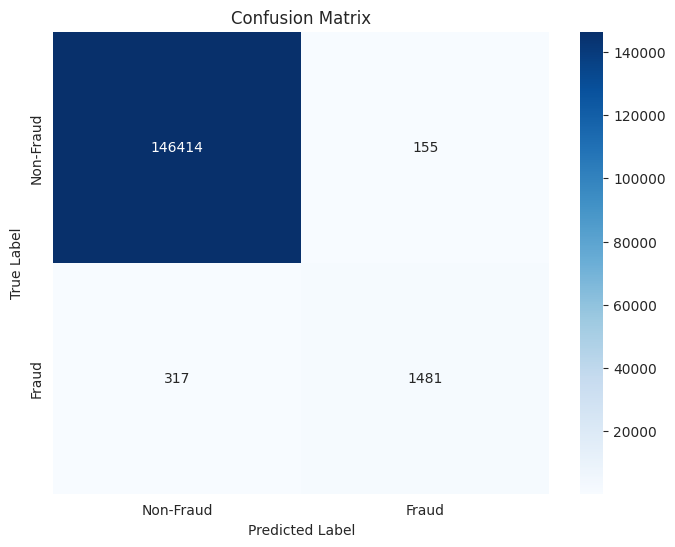

In [36]:
# raw dataset
if __name__ == "__main__":
    main(df_processed)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:34:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9940
Test Accuracy: 0.9934
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    146568
           1       0.99      1.00      0.99    146568

    accuracy                           0.99    293136
   macro avg       0.99      0.99      0.99    293136
weighted avg       0.99      0.99      0.99    293136

Confusion Matrix:
[[145073   1495]
 [   431 146137]]


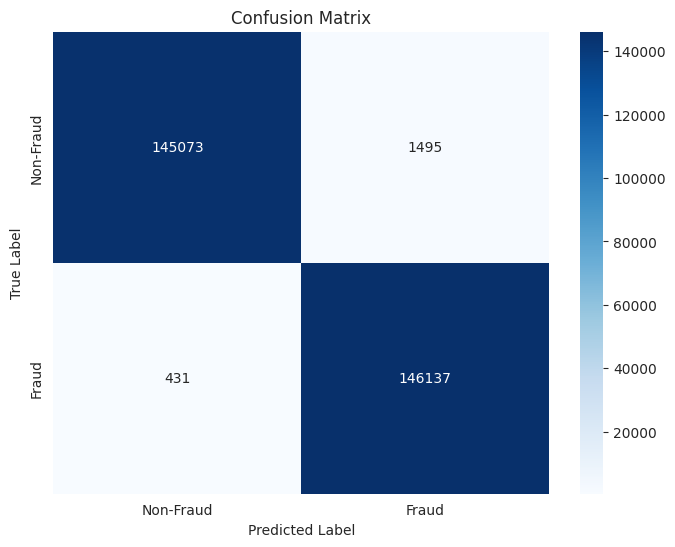

In [37]:
# SMOTE dataset
if __name__ == "__main__":
    main(df_processed_os)

## RAG

In [33]:
import faiss
print(faiss.__version__)

1.7.2


In [38]:
df_processed.dtypes

,0
timeStep,int64
customerId,int64
customerAge,int64
customerGender,int64
merchantName,int64
merchantCategory,int64
amount,float64
isFraud,int64
encoded_gender,int64
encoded_category,int64


In [53]:
df_subset

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
571549,173,1287167517,2,0,1823072687,12,54.91,0,0,12,0,1,29.710057
171192,59,1771717627,2,0,1823072687,12,6.04,0,0,12,0,1,25.744132
372854,119,947315968,2,0,348934600,12,3.42,0,0,12,0,1,33.170282
502406,155,822948524,3,0,348934600,12,25.35,0,0,12,0,1,140.242366
416389,131,1818021493,2,0,1823072687,12,41.26,0,0,12,0,1,32.062881
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319067,104,1783206868,5,0,348934600,12,23.88,0,0,12,0,1,28.599808
383282,122,1309194397,4,0,1823072687,12,45.19,0,0,12,0,1,29.589689
205837,70,1487982242,2,0,348934600,12,33.53,0,0,12,0,1,31.228675
55939,21,409740988,5,1,348934600,12,25.83,0,1,12,0,1,30.521412


Accuracy Score: 0.9970343809607257
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146652
           1       0.91      0.82      0.87      1715

    accuracy                           1.00    148367
   macro avg       0.95      0.91      0.93    148367
weighted avg       1.00      1.00      1.00    148367

AUC-ROC Score: 0.9972534312800483
Confusion Matrix:
[[146515    137]
 [   303   1412]]


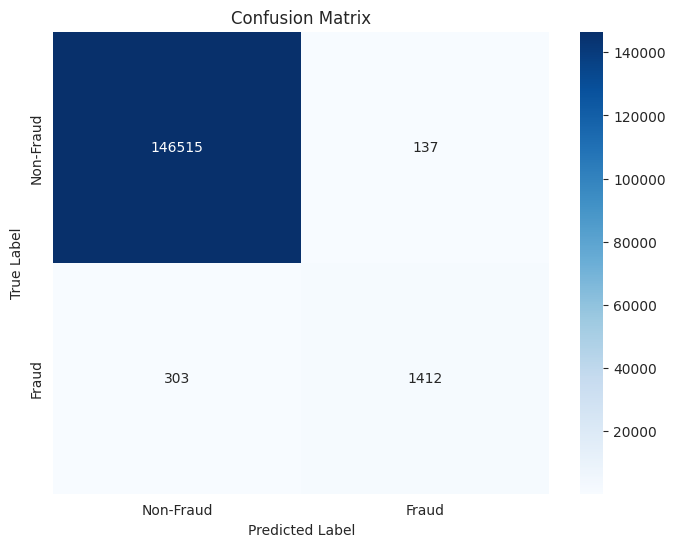

In [ ]:
import faiss
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Build FAISS Index with Cosine Similarity
# Extract features and target
features = df_processed_cos.drop(columns=['isFraud', 'customerGender', 'merchantCategory'])
target = df_processed_cos['isFraud'].values

# Create embeddings and normalize
embedding_matrix_cos = features.values.astype('float32')
embedding_matrix_cos = normalize(embedding_matrix, axis=1)  # Normalize for cosine similarity

# Ensure the array is C-contiguous
embedding_matrix_cos = np.ascontiguousarray(embedding_matrix_cos)

# Create FAISS index using Inner Product
dimension = embedding_matrix_cos.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product (Cosine Similarity when normalized)
index.add(embedding_matrix_cos)  # Add embeddings to the index

# Example usage: Retrieve similar transactions
def get_similar_transactions(transaction_vector, k=5):
    # Normalize and ensure the transaction vector is C-contiguous as well
    transaction_vector = normalize([transaction_vector], axis=1).astype('float32')
    transaction_vector = np.ascontiguousarray(transaction_vector)
    D, I = index.search(transaction_vector, k)  # Retrieve k nearest neighbors
    return I  # Return indices of similar transactions

# Example: Get similar transactions for the first transaction in the dataset
similar_transactions = get_similar_transactions(embedding_matrix_cos[0])

# Anomaly detection (this can be refined using statistical methods or additional ML models)
def detect_anomaly(transaction_vector, threshold=0.8):
    # Normalize and get similar transactions
    transaction_vector = normalize([transaction_vector], axis=1).astype('float32')
    similar_idx = get_similar_transactions(transaction_vector[0], k=10)
    similar_transactions = embedding_matrix_cos[similar_idx]
    mean_distance = np.mean(1 - np.dot(similar_transactions, transaction_vector[0]))  # Cosine dissimilarity = 1 - cosine similarity
    return mean_distance > threshold

# Step 4: Model Training
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Inference
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Classification Report
print(classification_report(y_test, y_pred))

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_roc}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualize Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Retrieval Model

In [ ]:
"""
import os

# File path to the FAISS index
index_file_path = 'faiss_index.index'

def delete_faiss_index(index_file_path):

    Delete the FAISS index file if it exists.

    Parameters:
    index_file_path (str): Path to the file where the FAISS index is saved.

    if os.path.exists(index_file_path):
        os.remove(index_file_path)
        print(f"FAISS index file {index_file_path} has been deleted.")
    else:
        print(f"FAISS index file {index_file_path} does not exist.")

# Call the function to delete the FAISS index file
delete_faiss_index(index_file_path)
"""

FAISS index file faiss_index.index has been deleted.


In [ ]:
import numpy as np
import faiss
import pandas as pd
import os

# Assume df_processed is already defined and processed
features = df_processed.drop(columns=['isFraud', 'customerGender', 'merchantCategory'])
embedding_matrix = features.values.astype('float32')

# File path to save/load the FAISS index
index_file_path = 'faiss_index.index'

def create_faiss_index(embedding_matrix, index_file_path):
    """
    Create a FAISS index from the embedding matrix and save it to a file.

    Parameters:
    embedding_matrix (np.ndarray): The matrix of embeddings to index.
    index_file_path (str): Path to the file where the FAISS index will be saved.
    """
    # Ensure the array is C-contiguous
    embedding_matrix = np.ascontiguousarray(embedding_matrix)

    dimension = embedding_matrix.shape[1]
    index = faiss.IndexFlatL2(dimension)  # L2 distance
    index.add(embedding_matrix)  # Add embeddings to the index
    faiss.write_index(index, index_file_path)
    print(f"FAISS index created and saved to {index_file_path}")

def load_faiss_index(index_file_path):
    """
    Load a FAISS index from a file.

    Parameters:
    index_file_path (str): Path to the file where the FAISS index is saved.

    Returns:
    faiss.Index: The loaded FAISS index.
    """
    return faiss.read_index(index_file_path)

def get_faiss_index(embedding_matrix, index_file_path):
    """
    Get the FAISS index. Create and save it if it doesn't exist, otherwise load it.

    Parameters:
    embedding_matrix (np.ndarray): The matrix of embeddings to index.
    index_file_path (str): Path to the file where the FAISS index will be saved/loaded.

    Returns:
    faiss.Index: The FAISS index.
    """
    if os.path.exists(index_file_path):
        print(f"Loading FAISS index from {index_file_path}")
        index = load_faiss_index(index_file_path)
    else:
        print(f"FAISS index not found. Creating new index.")
        create_faiss_index(embedding_matrix, index_file_path)
        index = load_faiss_index(index_file_path)
    return index

# Create or load the FAISS index
index = get_faiss_index(embedding_matrix, index_file_path)

def get_similar_transactions(transaction_vector, k=3):
    """
    Retrieve k most similar transactions to the given transaction vector along with their similarity scores.

    Parameters:
    transaction_vector (np.ndarray): The transaction vector to search for.
    k (int): Number of similar transactions to retrieve.

    Returns:
    tuple: A tuple containing two elements:
           - np.ndarray: Indices of the most similar transactions.
           - np.ndarray: Similarity scores (distances) of the most similar transactions.
    """
    transaction_vector = np.ascontiguousarray(transaction_vector).astype('float32')
    D, I = index.search(np.array([transaction_vector]), k)
    return I[0], D[0]



FAISS index not found. Creating new index.
FAISS index created and saved to faiss_index.index


In [ ]:
transaction_vector = embedding_matrix[88]  # Example transaction vector
similar_indices, similarity_scores = get_similar_transactions(transaction_vector)
print(f"Indices of similar transactions: {similar_indices}")
print(f"Similarity scores (distances): {similarity_scores}")

Indices of similar transactions: [   88  3901 16988]
Similarity scores (distances): [    0.    10995.523 41224.645]


In [ ]:
print(df_processed.iloc[88])

timeStep                             0
customerId                   583110837
customerAge                          3
customerGender                       M
merchantName                 480139044
merchantCategory             es_health
amount                           44.26
isFraud                              1
encoded_gender                       1
encoded_category                     4
IslargeTransaction                   0
countForCustomerSameTime             3
avgTransactionAmount        114.287643
Name: 88, dtype: object


In [ ]:
print(df_processed.iloc[3901])

timeStep                             1
customerId                   583110837
customerAge                          3
customerGender                       M
merchantName                 480139044
merchantCategory             es_health
amount                          149.11
isFraud                              1
encoded_gender                       1
encoded_category                     4
IslargeTransaction                   0
countForCustomerSameTime             2
avgTransactionAmount        114.287643
Name: 3906, dtype: object


In [ ]:
print(df_processed.iloc[16988])

timeStep                             6
customerId                   583110837
customerAge                          3
customerGender                       M
merchantName                 480139044
merchantCategory             es_health
amount                           247.2
isFraud                              0
encoded_gender                       1
encoded_category                     4
IslargeTransaction                   0
countForCustomerSameTime             1
avgTransactionAmount        114.287643
Name: 17015, dtype: object


## Experiment with Text embeddings using Sentence Transformer

In [ ]:
df_processed_before = df_processed.copy()

In [ ]:
df_processed = df_processed_before.copy()

In [ ]:
import pandas as pd

def categorize_amount(amount):
    """
    Categorize the amount into different spending categories.

    Parameters:
    amount (float): The amount to categorize.

    Returns:
    str: The category of the amount.
    """
    if amount < 1:
        return 'low amount'
    elif 1 <= amount < 100:
        return 'intermediate amount'
    elif 100 <= amount < 1000:
        return 'considerable amount'
    elif 1000 <= amount < 5000:
        return 'large amount'
    else:
        return 'hefty amount'

# Apply the categorize_amount function to the 'amount' column
df_processed['bhv_amount'] = df_processed['amount'].apply(categorize_amount)

# Categorize 'countForCustomerSameTime' into 'uncommon transaction' or 'recurring transaction'
df_processed['bhv_frequent'] = df_processed['countForCustomerSameTime'].apply(
    lambda x: 'uncommon transaction' if x == 1 else 'recurring transaction'
)

# Categorize 'isFraud' into 'fraud transaction' or 'genuine transaction'
df_processed['bhv_isFraud'] = df_processed['isFraud'].apply(
    lambda x: 'fraud transaction' if x == 1 else 'genuine transaction'
)

# Categorize 'customerGender' into 'male' or 'female'
df_processed['bhv_gender'] = df_processed['customerGender'].apply(
    lambda x: 'male' if x == 'M' else 'female'
)

# Convert 'customerAge' to numeric, handling errors by coercing to NaN
df_processed['customerAge'] = pd.to_numeric(df_processed['customerAge'], errors='coerce')

def categorize_customer_age(customer_age):
    """
    Categorize the customer age into different age groups.

    Parameters:
    customer_age (float): The customer age to categorize.

    Returns:
    str: The category of the customer age.
    """
    if pd.isna(customer_age):  # Handle NaN values
        return 'Unknown'
    elif customer_age < 2:
        return 'Child'
    elif 2 <= customer_age < 4:
        return 'Teen'
    else:
        return 'Adult'

# Apply the categorize_customer_age function to the 'customerAge' column
df_processed['bhv_customerAge'] = df_processed['customerAge'].apply(categorize_customer_age)


In [ ]:
# Create a new column 'transaction_behavior' with optimized string formatting
df_processed['transaction_behavior'] = df_processed.apply(
    lambda row: (
        f"A {row['bhv_frequent']} originated from "
        f"a {row['bhv_customerAge']} {row['bhv_gender']} customer {row['customerId']} "
        f"from merchant {row['merchantName']} "
        f"to category {row['merchantCategory']} "
        f"with {row['bhv_amount']} is categorized as {row['bhv_isFraud']}"
    ),
    axis=1
)

In [ ]:
df_processed.tail(5)

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,encoded_gender,encoded_category,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,bhv_amount,bhv_frequent,bhv_isFraud,bhv_gender,bhv_customerAge,transaction_behavior
594638,179,1753498738,3,F,1823072687,es_transportation,20.53,0,0,12,0,1,32.987283,intermediate amount,uncommon transaction,genuine transaction,female,Teen,A uncommon transaction originated from a Teen ...
594639,179,650108285,4,F,1823072687,es_transportation,50.73,0,0,12,0,1,35.111221,intermediate amount,uncommon transaction,genuine transaction,female,Adult,A uncommon transaction originated from a Adult...
594640,179,123623130,2,F,349281107,es_fashion,22.44,0,0,2,0,1,31.273988,intermediate amount,uncommon transaction,genuine transaction,female,Teen,A uncommon transaction originated from a Teen ...
594641,179,1499363341,5,M,1823072687,es_transportation,14.46,0,1,12,0,1,28.003091,intermediate amount,uncommon transaction,genuine transaction,male,Adult,A uncommon transaction originated from a Adult...
594642,179,616528518,4,F,1823072687,es_transportation,26.93,0,0,12,0,1,33.394833,intermediate amount,uncommon transaction,genuine transaction,female,Adult,A uncommon transaction originated from a Adult...


In [ ]:
# Using TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Sample data
text = ["Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction."]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(text)

# Convert the TF-IDF matrix to an array
tfidf_vector = tfidf_matrix.toarray()

print('Input Text :', text)
print('Empbedding :', tfidf_vector)
print('Empbedding Vector Shape :', tfidf_vector.shape)


Input Text : ['Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction.']
Empbedding : [[0.1767767  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767
  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767  0.35355339
  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767  0.1767767
  0.53033009 0.1767767  0.1767767 ]]
Empbedding Vector Shape : (1, 21)


In [ ]:
# Using Transformer Models (e.g., BERT)

from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Sample data
text = ["Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction."]

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

# Forward pass to get embeddings
with torch.no_grad():
    outputs = model(**inputs)

# Get the embeddings (use the last hidden state or pooled output)
embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

print('Input Text :', text)
print('Empbedding :', embeddings)
print('Empbedding Vector Shape :', embeddings.shape)

Input Text : ['Transaction Behavior: A uncommon transaction originated from Adult male customer 1038277619 from merchant 980657600 to category sportsandtoys with considerable amount is categorized as fraud transaction.']
Empbedding : [[-2.04234570e-01 -1.18125051e-01  2.63644397e-01 -6.16507083e-02
   4.33128417e-01 -1.15664281e-01  2.84974158e-01  7.95878619e-02
  -7.31031522e-02  2.00869218e-02 -8.47477838e-02 -2.44744882e-01
   7.73335546e-02  3.81787777e-01 -4.06663567e-01  3.00856292e-01
   1.07885271e-01  1.28784001e-01 -3.15052301e-01  6.26962334e-02
   9.92494226e-02 -6.90302253e-02  2.96023548e-01  8.69441628e-02
   3.46210599e-01  6.09874278e-02  3.82769369e-02 -3.59540395e-02
  -4.58155930e-01 -4.28352617e-02  7.03518331e-01  3.63010257e-01
   1.55987859e-01 -2.98625618e-01 -1.05050795e-01 -8.54200423e-02
  -9.92375836e-02 -3.34800303e-01 -1.88551128e-01  5.67641184e-02
  -2.43744731e-01 -1.11451335e-01 -2.04137012e-01  1.62768126e-01
   4.45893928e-02 -7.34888390e-02  1.939

In [ ]:
import pandas as pd

# Ensure that df_processed is not empty and has the expected columns
if df_processed is None or 'isFraud' not in df_processed.columns:
    raise ValueError("DataFrame is not loaded properly or missing 'isFraud' column")

# Filter the DataFrame based on isFraud values
fraud_records = df_processed[df_processed['isFraud'] == 1]
non_fraud_records = df_processed[df_processed['isFraud'] == 0]

# Calculate the number of records needed
total_records = 10000
fraud_percentage = 0.20
fraud_needed = int(total_records * fraud_percentage)
non_fraud_needed = total_records - fraud_needed

# Sample the required number of records
fraud_sample = fraud_records.sample(n=fraud_needed, random_state=1)
non_fraud_sample = non_fraud_records.sample(n=non_fraud_needed, random_state=1)

# Combine the sampled data
df_subset = pd.concat([fraud_sample, non_fraud_sample], ignore_index=True)

# Shuffle the DataFrame to randomize the order
df_subset = df_subset.sample(frac=1, random_state=1).reset_index(drop=True)

In [ ]:
df_before_subset = df_processed.copy()

In [ ]:
df_processed = df_before_subset.copy()

In [ ]:
df_processed = df_subset

In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss


def load_model(model_name: str = 'paraphrase-MiniLM-L6-v2') -> SentenceTransformer:
    """
    Load and return the SentenceTransformer model.

    Parameters:
    model_name (str): The name of the pre-trained model.

    Returns:
    SentenceTransformer: The loaded SentenceTransformer model.
    """
    return SentenceTransformer(model_name)


def generate_embeddings(df: pd.DataFrame, column: str, model: SentenceTransformer) -> pd.DataFrame:
    """
    Generate embeddings for a specific column in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the column to generate embeddings for.
    model (SentenceTransformer): The SentenceTransformer model.

    Returns:
    pd.DataFrame: The DataFrame with an additional column for embeddings.
    """
    df['embeddings'] = df[column].apply(lambda x: model.encode(x))
    return df


def initialize_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    """
    Initialize and return a FAISS index.

    Parameters:
    embeddings (np.ndarray): The embeddings to be added to the index.

    Returns:
    faiss.IndexFlatL2: The initialized FAISS index.
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index


def save_faiss_index(index: faiss.IndexFlatL2, filepath: str):
    """
    Save the FAISS index to disk.

    Parameters:
    index (faiss.IndexFlatL2): The FAISS index to be saved.
    filepath (str): The path where the index will be saved.
    """
    faiss.write_index(index, filepath)


def search_similar_transactions(query: str, model: SentenceTransformer, index: faiss.IndexFlatL2,
                                df: pd.DataFrame, k: int = 3) -> dict:
    """
    Search for similar transactions based on the query and return results.

    Parameters:
    query (str): The query string to find similar transactions.
    model (SentenceTransformer): The SentenceTransformer model.
    index (faiss.IndexFlatL2): The FAISS index.
    df (pd.DataFrame): The DataFrame containing the transaction behaviors.
    k (int): The number of similar items to retrieve.

    Returns:
    dict: Contains 'top_k_results' with transaction behaviors and similarity scores,
          and 'prediction' which is the last 2 words of the highest similarity transaction.
    """
    query_embedding = model.encode(query)
    D, I = index.search(np.array([query_embedding]), k)

    # Collect results
    top_k_results = []
    for idx, dist in zip(I[0], D[0]):
        result = {
            'transaction_behavior': df.iloc[idx]['transaction_behavior'],
            'similarity_score': 1 / (1 + dist)  # Convert distance to similarity score
        }
        top_k_results.append(result)

    # Extract the last 2 words of the highest similarity transaction
    highest_similarity_transaction = top_k_results[0]['transaction_behavior']
    prediction = ' '.join(highest_similarity_transaction.split()[-2:])

    return {
        'top_k_results': top_k_results,
        'prediction': prediction
    }


def display_results(results: dict):
    """
    Display the search results and prediction.

    Parameters:
    results (dict): Contains 'top_k_results' with transaction behaviors and similarity scores,
                    and 'prediction'.
    """
    print("Top K Results:")
    for i, res in enumerate(results['top_k_results']):
        print(f"Result {i+1}:")
        print(f"Transaction Behavior: {res['transaction_behavior']}")
        print(f"Similarity Score: {res['similarity_score']:.4f}")
        print("-" * 80)

    print("Prediction :")
    print("This transaction is a ", results['prediction'])



In [ ]:
if __name__ == "__main__":
    # Load data and model
    model = load_model()

    # Generate embeddings and add to DataFrame
    df_processed = generate_embeddings(df_processed, 'transaction_behavior', model)

    # Prepare embeddings and initialize FAISS index
    embeddings = np.vstack(df_processed['embeddings'].values)
    index = initialize_faiss_index(embeddings)

    # Optionally save the FAISS index
    save_faiss_index(index, "faiss_index_2.index")

In [ ]:
# Perform search with a query
query2 = "A uncommon transaction .. from a Teen male customer 976805632 .. category es_travel with large amount"
results = search_similar_transactions(query2, model, index, df_subset)

# Display the search results
display_results(results)

Top K Results:
Result 1:
Transaction Behavior: A uncommon transaction originated from a Teen male customer 976805632 from merchant 732195782 to category es_travel with large amount is categorized as fraud transaction
Similarity Score: 0.0834
--------------------------------------------------------------------------------
Result 2:
Transaction Behavior: A uncommon transaction originated from a Teen male customer 632538178 from merchant 732195782 to category es_travel with large amount is categorized as fraud transaction
Similarity Score: 0.0810
--------------------------------------------------------------------------------
Result 3:
Transaction Behavior: A uncommon transaction originated from a Teen male customer 475624028 from merchant 732195782 to category es_travel with considerable amount is categorized as fraud transaction
Similarity Score: 0.0806
--------------------------------------------------------------------------------
Prediction :
This transaction is a  fraud transaction


In [ ]:
# Perform search with a query
query2 = "A uncommon transaction .. Child female customer 1035222482 from merchant 348934600 to category es_transportation with intermediate"
results = search_similar_transactions(query2, model, index, df_subset)

# Display the search results
display_results(results)

Top K Results:
Result 1:
Transaction Behavior: A uncommon transaction originated from a Child female customer 203802515 from merchant 348934600 to category es_transportation with intermediate amount is categorized as genuine transaction
Similarity Score: 0.1244
--------------------------------------------------------------------------------
Result 2:
Transaction Behavior: A uncommon transaction originated from a Child female customer 2112350124 from merchant 348934600 to category es_transportation with intermediate amount is categorized as genuine transaction
Similarity Score: 0.1242
--------------------------------------------------------------------------------
Result 3:
Transaction Behavior: A uncommon transaction originated from a Child female customer 752270622 from merchant 348934600 to category es_transportation with intermediate amount is categorized as genuine transaction
Similarity Score: 0.1240
--------------------------------------------------------------------------------


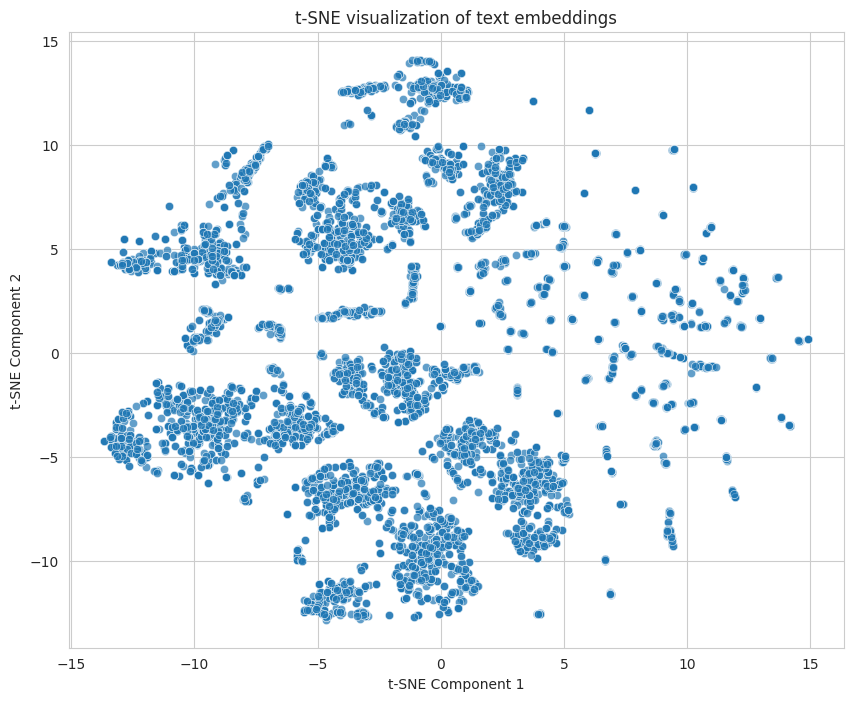

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings)

# Perform t-SNE for further dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(pca_result)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.7)
plt.title('t-SNE visualization of text embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(df: pd.DataFrame, model: SentenceTransformer, index: faiss.IndexFlatL2, queries: list, true_labels: list) -> dict:
    """
    Evaluate the model's performance on a set of queries.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the transaction behaviors and actual labels.
    model (SentenceTransformer): The SentenceTransformer model.
    index (faiss.IndexFlatL2): The FAISS index.
    queries (list): A list of query strings.
    true_labels (list): The actual labels corresponding to the queries.

    Returns:
    dict: Evaluation metrics including accuracy, precision, recall, and F1 score,
          and 'predictions_df' DataFrame with predictions and actual labels.
    """
    predictions = []
    actual_labels = []

    for query, true_label in zip(queries, true_labels):
        results = search_similar_transactions(query, model, index, df)
        predicted_label = results['prediction']

        # Collect actual and predicted labels
        actual_labels.append(true_label)
        predictions.append(predicted_label)

    # Calculate metrics
    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='binary', pos_label='fraud transaction')  # Adjust pos_label as necessary
    recall = recall_score(actual_labels, predictions, average='binary', pos_label='fraud transaction')
    f1 = f1_score(actual_labels, predictions, average='binary', pos_label='fraud transaction')

    # Create DataFrame with predictions and actual labels
    predictions_df = pd.DataFrame({
        'transaction_behavior': queries,
        'actual': actual_labels,
        'prediction': predictions
    })

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': classification_report(actual_labels, predictions),
        'predictions_df': predictions_df
    }

In [ ]:
# Path to the saved FAISS index file
index_file_path = 'faiss_index_2.index'

# Load the FAISS index
index = faiss.read_index(index_file_path)

# Verify that the index was loaded correctly
print(f"Loaded FAISS index with type: {type(index)}")

Loaded FAISS index with type: <class 'faiss.swigfaiss.IndexFlat'>


In [ ]:
if __name__ == "__main__":
    model = load_model()
    print(model)
    print(index)

    queries = df_processed['transaction_behavior'].tolist()
    true_labels = df_processed['bhv_isFraud'].tolist()

    # Evaluate the model
    metrics = evaluate_model(df_processed, model, index, queries, true_labels)

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("Classification Report:")
    print(metrics['classification_report'])

    print(metrics['predictions_df']['prediction'])

    # Append predictions to the sample DataFrame
    metrics['predictions_df']['prediction']
    metrics['predictions_df']['actual']

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)
<faiss.swigfaiss.IndexFlat; proxy of <Swig Object of type 'faiss::IndexFlat *' at 0x7a6af12d3a20> >
Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Classification Report:
                     precision    recall  f1-score   support

  fraud transaction       1.00      1.00      1.00      2000
genuine transaction       1.00      1.00      1.00      8000

           accuracy                           1.00     10000
          macro avg       1.00      1.00      1.00     10000
       weighted avg       1.00      1.00      1.00     10000



In [ ]:
metrics['predictions_df']

,transaction_behavior,actual,prediction
0,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction
1,A uncommon transaction originated from a Child...,genuine transaction,genuine transaction
2,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction
3,A uncommon transaction originated from a Adult...,genuine transaction,genuine transaction
4,A uncommon transaction originated from a Child...,genuine transaction,genuine transaction
...,...,...,...
9995,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction
9996,A uncommon transaction originated from a Adult...,genuine transaction,genuine transaction
9997,A recurring transaction originated from a Teen...,fraud transaction,fraud transaction
9998,A uncommon transaction originated from a Teen ...,genuine transaction,genuine transaction


Evaluation Metrics:
Average Precision: 0.8140
NDCG: 0.5307


<ipython-input-244-91d406a34b3d>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')


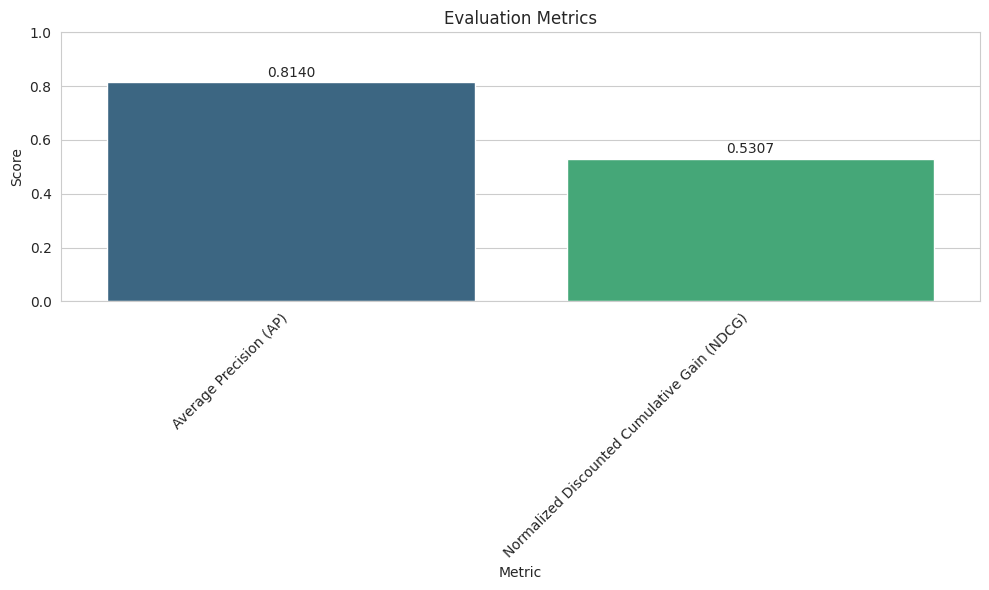

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, average_precision_score, ndcg_score

import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_similarity_search_advanced(df: pd.DataFrame, model: SentenceTransformer, index: faiss.IndexFlatL2, queries: list, true_labels: list, k: int = 3) -> dict:
    """
    Evaluate the similarity search model's performance on a set of queries.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the transaction behaviors and actual labels.
    model (SentenceTransformer): The SentenceTransformer model.
    index (faiss.IndexFlatL2): The FAISS index.
    queries (list): A list of query strings.
    true_labels (list): The actual labels corresponding to the queries.
    k (int): The number of top results to consider for evaluation.

    Returns:
    dict: Evaluation metrics including Precision@K, Recall@K, Average Precision, and NDCG.
    """
    all_relevant = []
    all_scores = []
    predictions = []

    for query, true_label in zip(queries, true_labels):
        results = search_similar_transactions(query, model, index, df, k)

        # Extract results
        top_k_results = results['top_k_results']
        predicted_label = results['prediction']

        # Collect the predicted label
        predictions.append(predicted_label)

        # Collect relevant items and their scores
        relevant_items = [1 if true_label in result['transaction_behavior'] else 0 for result in top_k_results]
        all_scores.extend([result['similarity_score'] for result in top_k_results])
        all_relevant.extend(relevant_items)

    # Precision at K
    precision_at_k = np.mean([sum([1 if item == 1 else 0 for item in relevant_items]) / k for relevant_items in [all_relevant]])

    # Recall at K
    recall_at_k = np.mean([sum(all_relevant) / len(true_labels)])

    # Mean Average Precision (MAP)
    average_precision = average_precision_score(all_relevant, all_scores)

    # NDCG
    if len(all_relevant) > 0:
        ndcg = ndcg_score([all_relevant], [all_scores], k=k)
    else:
        ndcg = 0.0

    return {
        'precision_at_k': precision_at_k,
        'recall_at_k': recall_at_k,
        'average_precision': average_precision,
        'ndcg': ndcg
    }



if __name__ == "__main__":
    model = load_model()

    # Prepare the sample
    sample_df = df_processed.sample(n=10, random_state=42)
    queries = sample_df['transaction_behavior'].str.slice(0, 120).tolist()
    true_labels = sample_df['bhv_isFraud'].tolist()

    # Initialize FAISS index and generate embeddings
    embeddings = np.vstack(df_processed['embeddings'].values)
    index = initialize_faiss_index(embeddings)

    # Evaluate the model
    metrics = evaluate_similarity_search_advanced(df_processed, model, index, queries, true_labels, k=3)

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"Average Precision: {metrics['average_precision']:.4f}")
    print(f"NDCG: {metrics['ndcg']:.4f}")

    # Metrics values
    metrics_dict = {
        'Average Precision (AP)': metrics['average_precision'],
        'Normalized Discounted Cumulative Gain (NDCG)': metrics['ndcg']
    }

    # Create a DataFrame for plotting
    metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Score'])

    # Plotting the metrics
    plt.figure(figsize=(10, 6))

    # Bar plot
    sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')

    # Add titles and labels
    plt.title('Evaluation Metrics')
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1)  # Set y-axis limits to [0, 1] since metric scores are typically in this range
    plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability

    # Add value annotations
    for index, row in metrics_df.iterrows():
        plt.text(index, row['Score'] + 0.02, f'{row["Score"]:.4f}', ha='center')

    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()


## More Generative

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

def load_model(model_name: str = 'paraphrase-MiniLM-L6-v2') -> SentenceTransformer:
    """
    Load and return the SentenceTransformer model.
    """
    return SentenceTransformer(model_name)

def generate_embeddings(df: pd.DataFrame, column: str, model: SentenceTransformer) -> pd.DataFrame:
    """
    Generate embeddings for a specific column in the DataFrame.
    """
    df['embeddings'] = df[column].apply(lambda x: model.encode(x))
    return df

def initialize_faiss_index(embeddings: np.ndarray) -> faiss.IndexFlatL2:
    """
    Initialize and return a FAISS index.
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

def search_and_generate_response(query: str, model: SentenceTransformer, index: faiss.IndexFlatL2,
                                 df: pd.DataFrame, api_key: str, k: int = 3, high_priority_terms: list = None) -> dict:
    """
    Search for similar transactions and generate a response based on the query and high-priority terms.
    """
    if high_priority_terms is None:
        high_priority_terms = []

    query_embedding = model.encode(query)
    D, I = index.search(np.array([query_embedding]), k)

    # Adjust the similarity scores based on high-priority terms
    results = []
    for idx, dist in zip(I[0], D[0]):
        transaction_behavior = df.iloc[idx]['transaction_behavior']
        similarity_score = 1 / (1 + dist)  # Convert distance to similarity score

        # Check for high-priority terms in the result
        priority_score = sum(term in transaction_behavior for term in high_priority_terms)
        adjusted_score = similarity_score + priority_score  # Adjust score

        result = {
            'transaction_behavior': transaction_behavior,
            'similarity_score': adjusted_score
        }
        results.append(result)

    # Sort results based on the adjusted score
    results = sorted(results, key=lambda x: x['similarity_score'], reverse=True)

    # Generate a response based on the top results
    response = generate_response(results, query, api_key)

    # Extract the highest similarity transaction
    highest_similarity_transaction = results[0]['transaction_behavior']
    prediction = ' '.join(highest_similarity_transaction.split()[-2:])

    return {
        'top_k_results': results,
        'prediction': prediction,
        'response': response
    }

In [ ]:
import openai

def generate_response(retrieved_docs: list, query: str, api_key: str) -> str:
    """
    Generate a response using a generative model based on the retrieved documents.
    """
    openai.api_key = api_key

    # Format the prompt for a chat-based model
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"Query: {query}"},
        {"role": "user", "content": "Documents:"},
        {"role": "user", "content": "\n".join(doc['transaction_behavior'] for doc in retrieved_docs)}
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",  # Or "gpt-4" depending on your access
        messages=messages,
        max_tokens=150,  # Adjust based on your needs
        temperature=0.7
    )

    return response.choices[0].message['content'].strip()

In [ ]:
if __name__ == "__main__":
    model = load_model()
    embeddings = np.vstack(df_processed['embeddings'].values)
    index = initialize_faiss_index(embeddings)

    # User Quyery
    query = "what is the type of A recurring transaction originated from a Teen male customer 180936571 from merchant 980657600 to category es_sportsandtoys with considerable amount is categorized as?"
    # Define words which needs high attention
    high_priority_terms = ["Teen", "considerable"]
    # For security purposes removed api key from the code. To generate the response assign an open_api_key to api_key variable

    api_key = #api-key-here

    # Perform search with a query and priority terms
    results = search_and_generate_response(query, model, index, df_processed, api_key, k=3, high_priority_terms=high_priority_terms)

    # Display the search results
    print("Top K Results:")
    for i, res in enumerate(results['top_k_results']):
        print(f"Result {i+1}:")
        print(f"Transaction Behavior: {res['transaction_behavior']}")
        print(f"Adjusted Similarity Score: {res['similarity_score']:.4f}")
        print("-" * 80)

    print("Prediction:")
    print(f"This transaction is a {results['prediction']}")

    print("Generated Response:")
    print(results['response'])


Top K Results:
Result 1:
Transaction Behavior: A recurring transaction originated from a Teen male customer 1358079072 from merchant 1741626453 to category es_sportsandtoys with considerable amount is categorized as fraud transaction
Adjusted Similarity Score: 2.1247
--------------------------------------------------------------------------------
Result 2:
Transaction Behavior: A recurring transaction originated from a Teen male customer 1955375790 from merchant 17379832 to category es_sportsandtoys with considerable amount is categorized as fraud transaction
Adjusted Similarity Score: 2.1242
--------------------------------------------------------------------------------
Result 3:
Transaction Behavior: A recurring transaction originated from a Teen male customer 1714895875 from merchant 1741626453 to category es_sportsandtoys with intermediate amount is categorized as genuine transaction
Adjusted Similarity Score: 1.1514
----------------------------------------------------------------

# RAG Test

In [ ]:
# removing originZipCode and merchantZipCode as both are similar across all records

df_processed_rag = df_processed_rag.drop(columns=['originZipCode', 'merchantZipCode'])


In [ ]:
def categorize_amount(amount):
    if amount < 1:
        return 'very less amount'
    elif 1 <= amount < 100:
        return 'low amount'
    elif 100 <= amount < 1000:
        return 'intermediate amount'
    elif 1000 <= amount < 5000:
        return 'large amount'
    else:
        return 'very large amount'

df_processed_rag['bhv_amount'] = df_processed_rag['amount'].apply(categorize_amount)


In [ ]:
df_processed_rag['bhv_frequent'] = df_processed_rag['countForCustomerSameTime'].apply(
    lambda x: 'uncommon transaction' if x == 1 else 'recurring transaction'
)

In [ ]:
df_processed_rag['bhv_isFraud'] = df_processed_rag['isFraud'].apply(
    lambda x: 'fraudlent transaction' if x == 1 else 'genuine transaction'
)

In [ ]:
df_processed_rag['customerAge'] = pd.to_numeric(df_processed_rag['customerAge'], errors='coerce')

def categorize_customerAge(customerAge):
    if pd.isna(customerAge):  # Handle NaN values
        return 'Unknown'
    elif customerAge < 2:
        return 'Teenage'
    elif 2 <= customerAge < 4:
        return 'Young Adults'
    else:
        return 'Adults'

df_processed_rag['bhv_customerAge'] = df_processed_rag['customerAge'].apply(categorize_customerAge)



In [ ]:
df_processed_rag['transaction_behavior'] = df_processed_rag.apply(
    lambda row: f"A {row['bhv_frequent']} originated from {row['bhv_customerAge']} customer {row['customerId']} "
                f"from merchant {row['merchantName']} to category {row['merchantCategory']} "
                f"with {row['bhv_amount']} is categorized as {row['bhv_isFraud']}",
    axis=1
)

In [ ]:
# Write pre-processed data to .csv files for manual analysis

# Specifying the filename
output_file = 'df_processed_rag.csv'

# Export the DataFrame to CSV
df_processed_rag.to_csv(output_file, index=False)

print(f"DataFrame has been exported to {output_file}")


DataFrame has been exported to df_processed_rag.csv


In [ ]:
df_subset = df_processed_rag.head(1000)

In [ ]:
pip install transformers faiss-gpu pandas numpy


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Function to generate embeddings
def generate_embedding(text, max_length=512):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
    return embeddings

# Apply the function to generate embeddings for each transaction behavior
df_subset['embedding'] = df_subset['transaction_behavior'].apply(generate_embedding)


<ipython-input-94-225019f92b8d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['embedding'] = df_subset['transaction_behavior'].apply(generate_embedding)


In [ ]:
# Store generated embeddings in a vector store
import faiss
import numpy as np

# Convert the embeddings to a NumPy array
embeddings = np.vstack(df_subset['embedding'].values)

# Define the dimension of the embeddings
embedding_dim = embeddings.shape[1]

# Create a FAISS index
index = faiss.IndexFlatL2(embedding_dim)

# Add embeddings to the index
index.add(embeddings)

# Optionally, save the FAISS index to disk
faiss.write_index(index, 'transaction_behavior_index.faiss')


In [ ]:
# Querying the vector store

# Example query (assuming a new transaction behavior string)
query_text = "A uncommen transaction originated from Young Adults with low amount"
query_embedding = generate_embedding(query_text).reshape(1, -1)

# Search the index
D, I = index.search(query_embedding, k=1)  # Retrieve top 5 closest vectors

# Retrieve corresponding records
similar_records = df_processed_rag.iloc[I[0]]
print(similar_records)


     timeStep   customerId  customerAge customerGender merchantName  \
591         0  C1681589600            2              F  M1823072687   

      merchantCategory  amount  isFraud  IslargeTransaction  \
591  es_transportation    7.56        0                   0   

     countForCustomerSameTime  avgTransactionAmount  bhv_amount  \
591                         1             32.512022  low amount   

             bhv_frequent bhv_customerAge  \
591  uncommon transaction    Young Adults   

                                  transaction_behavior          bhv_isFraud  
591  A uncommon transaction originated from Young A...  genuine transaction  


In [ ]:
def generate_classification_prompt(transaction_description, similar_transactions):
    prompt = f"Given the following transactions:\n{similar_transactions}\n\nClassify this transaction:\n{transaction_description}\n\nIs this transaction fraudulent or genuine?"
    return prompt

def classify_transaction(transaction_description):
    query_embedding = generate_embedding(transaction_description).reshape(1, -1)

    # Retrieve similar transactions
    D, I = index.search(query_embedding, k=3)
    similar_transactions = df_processed_rag.iloc[I[0]]['transaction_behavior'].tolist()

    # Create a classification prompt
    prompt = generate_classification_prompt(transaction_description, "\n".join(similar_transactions))

    # Generate a response using GPT-2 or similar model
    inputs = gpt2_tokenizer(prompt, return_tensors='pt', max_length=512, truncation=True)
    outputs = gpt2_model.generate(**inputs, max_new_tokens=50)
    response = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response

# Example usage
transaction_description = "A uncommen transaction originated from Young Adults with low amount"
classification = classify_transaction(transaction_description)
print(classification)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Given the following transactions:
A uncommon transaction originated from Young Adults customer C1681589600 from merchant M1823072687 to category es_transportation with low amount is categorized as genuine transaction
A uncommon transaction originated from Young Adults customer C1060470494 from merchant M1823072687 to category es_transportation with low amount is categorized as genuine transaction
A uncommon transaction originated from Young Adults customer C161101673 from merchant M1823072687 to category es_transportation with low amount is categorized as genuine transaction

Classify this transaction:
A uncommen transaction originated from Young Adults with low amount

Is this transaction fraudulent or genuine?

A transaction originated from Young Adults customer C161101673 from merchant M1823072687 to category es_transportation with low amount is categorized as genuine transaction

A transaction originated from Young Adults customer C161101673


In [ ]:
query_embedding = generate_embedding(transaction_description).reshape(1, -1)
D, I = index.search(query_embedding, k=5)
similar_transactions = df_processed_rag.iloc[I[0]]['transaction_behavior'].tolist()

In [ ]:
df_subset[df_subset['isFraud'] == 1].head()

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,bhv_amount,bhv_frequent,bhv_customerAge,transaction_behavior,bhv_isFraud,embedding
88,0,C583110837,3,M,M480139044,es_health,44.26,1,0,3,114.287643,low amount,recurring transaction,Young Adults,A recurring transaction originated from Young ...,fraudlent transaction,"[-0.11552497, 0.17454731, -0.05036496, -0.1420..."
89,0,C1332295774,3,M,M480139044,es_health,324.50,1,0,1,134.065849,intermediate amount,uncommon transaction,Young Adults,A uncommon transaction originated from Young A...,fraudlent transaction,"[-0.062864356, 0.17927471, -0.065637514, -0.17..."
434,0,C1160421902,3,M,M857378720,es_hotelservices,176.32,1,0,1,45.603140,intermediate amount,uncommon transaction,Young Adults,A uncommon transaction originated from Young A...,fraudlent transaction,"[-0.020672405, 0.17260832, -0.07500544, -0.087..."
435,0,C966214713,3,M,M857378720,es_hotelservices,337.41,1,0,1,39.378900,intermediate amount,uncommon transaction,Young Adults,A uncommon transaction originated from Young A...,fraudlent transaction,"[-0.06483217, 0.16667625, -0.06426297, -0.0666..."
553,0,C1450140987,4,F,M1198415165,es_wellnessandbeauty,220.11,1,0,1,74.301611,intermediate amount,uncommon transaction,Adults,A uncommon transaction originated from Adults ...,fraudlent transaction,"[-0.09511135, 0.15435031, -0.008027926, -0.120..."


# RAG

In [ ]:
import pandas as pd

def sample_records(df, total_records=10000, fraud_fraction=0.05, random_state=1):
    """
    Samples a subset from the given DataFrame with a specific total number of records
    and a specified fraction of fraudulent records. This is done to mitigate
    computation overhead when calling OPEN_API

    Parameters:
    - df: pd.DataFrame
        The input DataFrame containing the records.
    - total_records: int, optional (default=10000)
        Total number of records in the output DataFrame.
    - fraud_fraction: float, optional (default=0.05)
        The fraction of records that should be fraudulent.
    - random_state: int, optional (default=1)
        Seed for the random number generator (for reproducibility).

    Returns:
    - pd.DataFrame
        A DataFrame containing the sampled records with the desired proportion
        of fraudulent and non-fraudulent records.
    """
    # Separate records where isFraud = 1
    fraudulent_records = df[df['isFraud'] == 1]

    # Separate records where isFraud = 0
    non_fraudulent_records = df[df['isFraud'] == 0]

    # Calculate the number of samples needed for each group
    fraudulent_sample_size = int(total_records * fraud_fraction)
    non_fraudulent_sample_size = total_records - fraudulent_sample_size

    # Sample from each group
    sampled_fraudulent = fraudulent_records.sample(
        n=fraudulent_sample_size,
        random_state=random_state
    )
    sampled_non_fraudulent = non_fraudulent_records.sample(
        n=non_fraudulent_sample_size,
        random_state=random_state
    )

    # Combine the sampled data
    sampled_df = pd.concat([sampled_fraudulent, sampled_non_fraudulent])

    # Shuffle the combined DataFrame
    sampled_df = sampled_df.sample(
        frac=1,
        random_state=random_state
    ).reset_index(drop=True)

    return sampled_df


In [ ]:
sampled_df = sample_records(df_processed_rag, total_records=10000, fraud_fraction=0.05)

In [ ]:
print(sampled_df.head())
print(sampled_df['isFraud'].value_counts())

   timeStep   customerId customerAge  customerGender originZipCode  \
0       135   C703281362           2               0         28007   
1        69   C686064678           2               0         28007   
2       163  C1702404555           3               1         28007   
3        40   C956794113           3               0         28007   
4        47   C861002792           3               0         28007   

  merchantName merchantZipCode  merchantCategory  amount  isFraud  \
0  M1823072687           28007                12    5.72        0   
1  M1823072687           28007                12    9.25        0   
2  M1823072687           28007                12    3.74        0   
3  M1823072687           28007                12   39.26        0   
4  M1823072687           28007                12   25.15        0   

   IslargeTransaction  countForCustomerSameTime  avgTransactionAmount  
0                   0                         1             30.764675  
1                   

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data_for_rag(df, feature_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Preprocesses the data by selecting features, splitting into train and test sets, and scaling the features.

    Parameters:
    - df: pd.DataFrame
        The input DataFrame containing the data.
    - feature_columns: list of str
        List of column names to be used as features.
    - target_column: str, optional (default='isFraud')
        The column name to be used as the target variable.
    - test_size: float, optional (default=0.5)
        The proportion of the dataset to include in the test split.
    - random_state: int, optional (default=42)
        Seed for the random number generator (for reproducibility).

    Returns:
    - X_train_scaled: numpy.ndarray
        Scaled training features.
    - X_test_scaled: numpy.ndarray
        Scaled test features.
    - y_train: pd.Series
        Training target values.
    - y_test: pd.Series
        Test target values.
    """
    # Select features and target
    features = df[feature_columns].copy()
    X = features.drop(columns=[target_column])
    y = features[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


In [ ]:
column_list = ['timeStep','customerAge','customerGender','merchantCategory','amount','isFraud','IslargeTransaction','countForCustomerSameTime','avgTransactionAmount']
rag_processed_df = preprocess_data_for_rag(sampled_df, column_list)

In [ ]:
import os
import openai
import concurrent.futures
import pandas as pd

# Set API Key
##os.environ["OPENAI_API_KEY"] =
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_embeddings_parallel(texts):
    """
    Retrieve embeddings for a list of texts using parallel processing.

    Parameters:
    - texts: list of str
        The list of texts for which embeddings are to be retrieved.

    Returns:
    - list of list of float
        The embeddings for each text.
    """
    def get_single_embedding(text):
        response = openai.Embedding.create(
            model="text-embedding-ada-002",
            input=text
        )
        return response['data'][0]['embedding']

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map the executor to the function and texts
        futures = [executor.submit(get_single_embedding, text) for text in texts]
        return [future.result() for future in concurrent.futures.as_completed(futures)]

def add_embeddings_to_df(df, text_column, embedding_column='embedding'):
    """
    Adds embeddings for a text column to the DataFrame.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the text data.
    - text_column: str
        The name of the column containing the text data.
    - embedding_column: str, optional (default='embedding')
        The name of the column to add with the embeddings.

    Returns:
    - pd.DataFrame
        The DataFrame with an additional column containing embeddings.
    """
    texts = df[text_column].tolist()
    embeddings = get_embeddings_parallel(texts)

    df[embedding_column] = embeddings
    return df


In [ ]:
rag_processed_df = features.loc[X_test.index]
print("Number of rows in rag_processed_df:", len(rag_processed_df))

Number of rows in rag_processed_df: 5000


In [ ]:
import numpy as np

def generate_embeddings_for_features(df, feature_columns, embedding_function, embedding_column='embedding'):
    """
    Combines specified feature columns into a single string, retrieves embeddings for the combined strings,
    and returns a DataFrame with embeddings as a 2D array.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the feature columns.
    - feature_columns: list of str
        List of column names to be combined into a single string.
    - embedding_function: function
        Function that takes a list of texts and returns a list of embeddings.
    - embedding_column: str, optional (default='embedding')
        The name of the column to add with the embeddings.

    Returns:
    - pd.DataFrame
        The original DataFrame with an additional column containing embeddings as a 2D array.
    - np.ndarray
        A 2D numpy array where each row represents the flattened embedding of a combined feature string.
    """
    # Convert specified columns to string type and combine them into a single string
    for col in feature_columns:
        df[col] = df[col].astype(str)

    df['combined_features'] = df[feature_columns].apply(lambda row: ' '.join(row), axis=1)

    # Get embeddings for the combined column
    combined_texts = df['combined_features'].tolist()
    embeddings_list = embedding_function(combined_texts)

    # Flatten each embedding to make it 1D and convert to a 2D array
    embeddings_array = np.array([np.array(embedding).flatten() for embedding in embeddings_list])

    # Add the embeddings to the DataFrame
    df[embedding_column] = list(embeddings_array)

    return df, embeddings_array

In [ ]:
# Example usage
feature_columns = ['customerAge', 'customerGender', 'amount',
                   'IslargeTransaction', 'countForCustomerSameTime',
                   'avgTransactionAmount', 'isFraud']

df_test_with_embeddings, embeddings_array = generate_embeddings_for_features(
    rag_processed_df,
    feature_columns,
    get_embeddings_parallel
)

print("Number of rows in df_test_with_embeddings:", len(df_test_with_embeddings))
print("Shape of embeddings_array:", embeddings_array.shape)

Number of rows in df_test_with_embeddings: 5000
Shape of embeddings_array: (5000, 1536)


In [ ]:
embeddings_array

array([[ 0.00730173,  0.00072604, -0.00116555, ..., -0.00481725,
        -0.00018077, -0.02052305],
       [-0.00218893, -0.00120013,  0.00152228, ...,  0.00423696,
        -0.00250335, -0.01714028],
       [ 0.01303572, -0.00176006, -0.00527848, ..., -0.00956681,
        -0.02189236, -0.00975801],
       ...,
       [-0.0087584 , -0.00387391,  0.00225529, ..., -0.00448026,
        -0.01313087, -0.00931086],
       [ 0.00813869, -0.00677314,  0.00069857, ...,  0.00282669,
        -0.01224217, -0.00183667],
       [ 0.00575101,  0.00339739, -0.00948316, ..., -0.00983337,
         0.00061501, -0.01532688]])

In [ ]:
# Normalize the embeddings using StandardScaler
scaler = StandardScaler()
try:
    normalized_embeddings = scaler.fit_transform(embeddings_array)
except ValueError as e:
    print("Error during normalization:", e)
    print("Shape of embeddings array before normalization:", embeddings_array.shape)

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Calculate cosine dissimilarity matrix (1 - cosine similarity)
cosine_dissimilarity_matrix = squareform(pdist(normalized_embeddings, 'cosine'))

In [ ]:
import matplotlib.pyplot as plt

def test_threshold_multipliers(cosine_dissimilarity_matrix, multipliers=[1.0, 1.5, 2.0, 3.0]):
    flattened_matrix = cosine_dissimilarity_matrix.flatten()
    plt.figure(figsize=(12, 8))

    for multiplier in multipliers:
        mean_dissimilarity = np.mean(flattened_matrix)
        std_dissimilarity = np.std(flattened_matrix)
        threshold = mean_dissimilarity + multiplier * std_dissimilarity

        anomalies = np.sum(flattened_matrix > threshold)
        plt.hist(flattened_matrix[flattened_matrix <= threshold], bins=30, alpha=0.5, label=f'Below Threshold {multiplier}')
        plt.hist(flattened_matrix[flattened_matrix > threshold], bins=30, alpha=0.5, label=f'Above Threshold {multiplier}')
        print(f"Multiplier: {multiplier}, Number of anomalies detected: {anomalies}")

    plt.legend()
    plt.xlabel('Dissimilarity Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Dissimilarity Scores with Various Thresholds')
    plt.show()

Multiplier: 1.0, Number of anomalies detected: 3386088
Multiplier: 1.5, Number of anomalies detected: 746806
Multiplier: 2.0, Number of anomalies detected: 72426
Multiplier: 3.0, Number of anomalies detected: 18


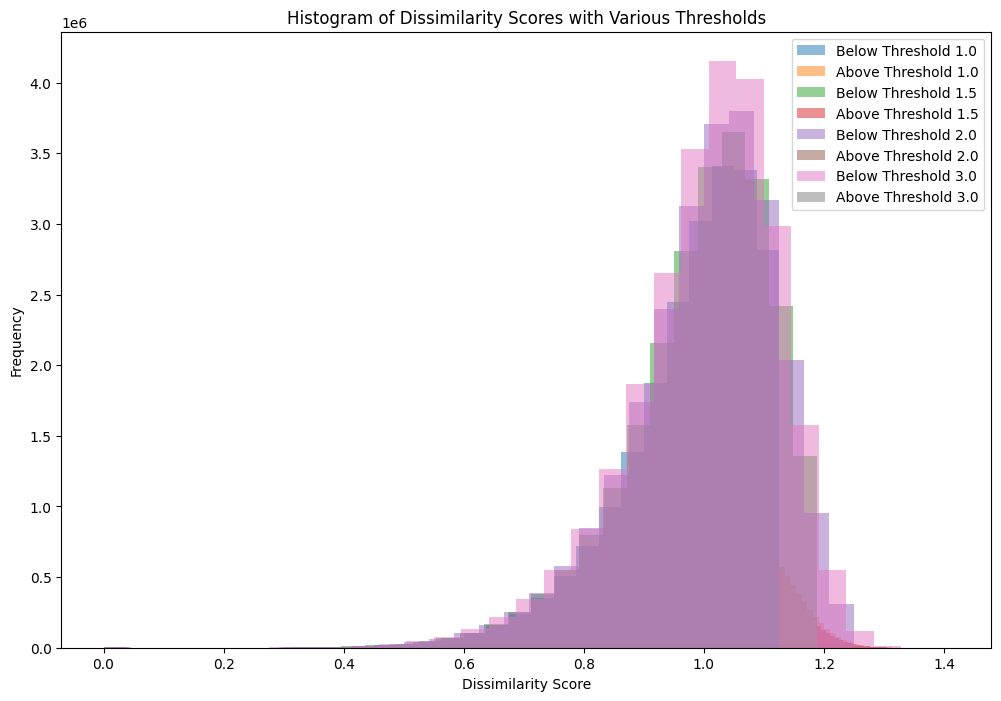

In [ ]:
test_threshold_multipliers(cosine_dissimilarity_matrix)

In [ ]:
def detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier=2.5):
    """
    Detects anomalies in a cosine dissimilarity matrix based on a calculated threshold.

    Parameters:
    - cosine_dissimilarity_matrix: np.ndarray
        A 2D numpy array representing the cosine dissimilarity matrix.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.

    Returns:
    - threshold: float
        The calculated threshold for identifying anomalies.
    - anomaly_indices: tuple of np.ndarray
        Indices of the anomalies in the dissimilarity matrix.
    """
    # Calculate mean and standard deviation of the dissimilarity matrix
    mean_dissimilarity = np.mean(cosine_dissimilarity_matrix)
    std_dissimilarity = np.std(cosine_dissimilarity_matrix)

    # Compute the threshold for anomalies
    threshold = mean_dissimilarity + threshold_multiplier * std_dissimilarity

    # Identify indices of the anomalies
    anomaly_indices = np.where(cosine_dissimilarity_matrix > threshold)

    return threshold, anomaly_indices

In [ ]:
threshold, anomaly_indices = detect_anomalies(cosine_dissimilarity_matrix)

print("Threshold for anomalies:", threshold)
print("Anomaly indices:", anomaly_indices)

Threshold for anomalies: 1.3132440125409626
Anomaly indices: (array([   1,    1,    1, ..., 4994, 4997, 4997]), array([ 421, 1996, 4395, ..., 2266,  523, 3000]))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

def detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier=2.5):
    flattened_matrix = cosine_dissimilarity_matrix.flatten()
    mean_dissimilarity = np.mean(flattened_matrix)
    std_dissimilarity = np.std(flattened_matrix)
    threshold = mean_dissimilarity + threshold_multiplier * std_dissimilarity
    anomaly_indices = np.argwhere(cosine_dissimilarity_matrix > threshold)
    return threshold, anomaly_indices

def mark_anomalies_in_df(df, cosine_dissimilarity_matrix, threshold_multiplier=2.5, anomaly_column='embedding_cosine_isAnomaly'):
    threshold, anomaly_indices = detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier)
    anomaly_pairs = list(zip(anomaly_indices[0], anomaly_indices[1]))
    anomaly_transactions = set()
    for i, j in anomaly_pairs:
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)
    index_mapping = df.index.tolist()
    mapped_anomaly_indices = [index_mapping[i] for i in anomaly_transactions]
    df[anomaly_column] = 0
    df.loc[mapped_anomaly_indices, anomaly_column] = 1
    return df

def evaluate_thresholds(df, cosine_dissimilarity_matrix, thresholds, ground_truth_indices):
    results = []
    for threshold_multiplier in thresholds:
        df_with_anomalies = mark_anomalies_in_df(df, cosine_dissimilarity_matrix, threshold_multiplier)
        predicted_anomalies = df_with_anomalies['embedding_cosine_isAnomaly'].values
        ground_truth = np.zeros(len(df))
        ground_truth[ground_truth_indices] = 1
        precision, recall, _ = precision_recall_curve(ground_truth, predicted_anomalies)
        f1 = f1_score(ground_truth, predicted_anomalies)
        results.append({
            'threshold_multiplier': threshold_multiplier,
            'f1_score': f1,
            'precision': precision.mean(),
            'recall': recall.mean()
        })
    return pd.DataFrame(results)

In [ ]:
ground_truth_indices = rag_processed_df.index[rag_processed_df['isFraud'] == '1'].tolist()

# Sort indices in ascending order
ground_truth_indices = sorted(ground_truth_indices)

# Pick the first five elements from the sorted list
ground_truth_indices = ground_truth_indices[:5]
print(f"Ground truth indices: {ground_truth_indices}")

Ground truth indices: [70, 90, 91, 227, 274]


   threshold_multiplier  f1_score  precision    recall
0                   1.0       0.0   0.333667  0.333333
1                   1.5       0.0   0.333667  0.333333
2                   2.0       0.0   0.333667  0.333333
3                   2.5       0.0   0.333667  0.333333
4                   3.0       0.0   0.333667  0.333333


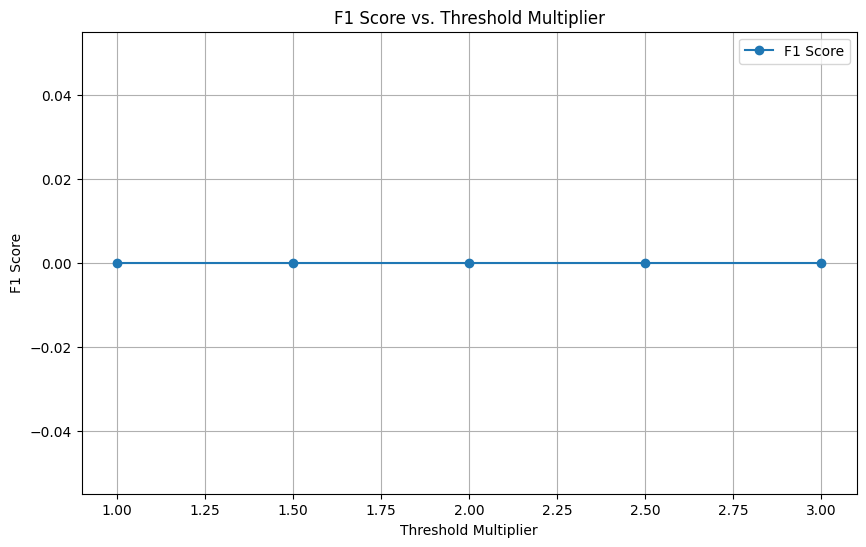

In [ ]:
# Define ground truth indices (for example purposes, assume indices 10 to 14 are anomalies)
ground_truth_indices = ground_truth_indices

# Define threshold multipliers to test
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]

# Evaluate thresholds
results_df = evaluate_thresholds(rag_processed_df, cosine_dissimilarity_matrix, thresholds, ground_truth_indices)

# Print results
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold_multiplier'], results_df['f1_score'], marker='o', label='F1 Score')
plt.xlabel('Threshold Multiplier')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold Multiplier')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def mark_anomalies_in_df(df, cosine_dissimilarity_matrix, threshold_multiplier=2.5, anomaly_column='embedding_cosine_isAnomaly'):
    """
    Identifies and marks anomalies in the DataFrame based on the cosine dissimilarity matrix.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the transactions.
    - cosine_dissimilarity_matrix: np.ndarray
        A square 2D numpy array representing the cosine dissimilarity matrix.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.
    - anomaly_column: str, optional (default='embedding_cosine_isAnomaly')
        The name of the column to add with the anomaly indicator (0 or 1).

    Returns:
    - pd.DataFrame
        The DataFrame with an additional column marking anomalies.
    """
    # Detect anomalies
    threshold, anomaly_indices = detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier)

    # Since cosine_dissimilarity_matrix is a square matrix, we get pairs of indices
    anomaly_pairs = list(zip(anomaly_indices[0], anomaly_indices[1]))

    # Map these pairs back to the original transactions
    anomaly_transactions = set()
    for i, j in anomaly_pairs:
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)

    # Create a mapping from new indices to original indices
    index_mapping = df.index.tolist()

    # Map the anomaly indices to original indices
    mapped_anomaly_indices = [index_mapping[i] for i in anomaly_transactions]

    # Add an 'embedding_cosine_isAnomaly' column to the DataFrame
    df[anomaly_column] = 0
    df.loc[mapped_anomaly_indices, anomaly_column] = 1

    return df

In [ ]:
df_test_with_anomalies = mark_anomalies_in_df(rag_processed_df, cosine_dissimilarity_matrix)

print("DataFrame with anomalies marked:")
print(df_test_with_anomalies)


DataFrame with anomalies marked:
     timeStep customerAge customerGender  merchantCategory  amount isFraud  \
6252      133           4              0                12   31.46       0   
4684       31           5              0                10  295.39       1   
1731       41           2              1                 0   30.73       0   
4742      128           3              0                12   14.04       0   
4521      137           2              0                12   11.38       0   
...       ...         ...            ...               ...     ...     ...   
5743      136           3              1                12   25.21       0   
6226      173           1              0                 6  139.39       1   
1973      102           2              0                12   14.53       0   
336       163           2              1                 3   67.99       0   
2764      155           2              1                12    0.02       0   

     IslargeTransaction countF

In [ ]:
df_test_with_anomalies[df_test_with_anomalies['embedding_cosine_isAnomaly'] == 1]

,timeStep,customerAge,customerGender,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,combined_features,embedding,embedding_cosine_isAnomaly
1498,161,5,1,12,26.57,0,0,1,29.383086419753088,5 1 26.57 0 1 29.383086419753088 0,"[0.00234853639267385, -0.006333931349217892, 0...",1
8285,175,1,1,12,14.02,0,0,1,32.93335227272728,1 1 14.02 0 1 32.93335227272728 0,"[0.007576659321784973, -0.0014738020254299045,...",1


In [ ]:
from scipy.spatial.distance import pdist, squareform

def detect_and_mark_anomalies(df, normalized_embeddings, threshold_multiplier=2.5, anomaly_column='embedding_euclidean_isAnomaly'):
    """
    Detects anomalies based on the Euclidean distance matrix and marks them in the DataFrame.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the transactions.
    - normalized_embeddings: np.ndarray
        A 2D numpy array where each row is an embedding vector.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.
    - anomaly_column: str, optional (default='embedding_euclidean_isAnomaly')
        The name of the column to add with the anomaly indicator (0 or 1).

    Returns:
    - pd.DataFrame
        The DataFrame with an additional column marking anomalies.
    """
    # Calculate Euclidean distance matrix
    euclidean_distance_matrix = squareform(pdist(normalized_embeddings, 'euclidean'))

    # Find the threshold for anomalies using Euclidean distance
    mean_euclidean = np.mean(euclidean_distance_matrix)
    std_euclidean = np.std(euclidean_distance_matrix)
    threshold_euclidean = mean_euclidean + threshold_multiplier * std_euclidean

    # Extract anomalies from distance matrix
    def extract_anomalies(distance_matrix, threshold):
        anomaly_indices = np.where(distance_matrix > threshold)
        anomaly_transactions = set()
        for i, j in zip(*anomaly_indices):
            if i != j:
                anomaly_transactions.add(i)
                anomaly_transactions.add(j)
        return anomaly_transactions

    euclidean_anomalies = extract_anomalies(euclidean_distance_matrix, threshold_euclidean)

    # Create a mapping from new indices to original indices
    index_mapping = df.index.tolist()

    # Map the anomaly indices to original indices
    mapped_euclidean_anomalies = [index_mapping[i] for i in euclidean_anomalies]

    # Add an 'embedding_euclidean_isAnomaly' column to the DataFrame
    df[anomaly_column] = 0
    df.loc[mapped_euclidean_anomalies, anomaly_column] = 1

    return df

In [ ]:
df_test_with_anomalies = detect_and_mark_anomalies(df_test_with_anomalies, normalized_embeddings)

In [ ]:
df_test_with_anomalies

,timeStep,customerAge,customerGender,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,combined_features,embedding,embedding_cosine_isAnomaly,embedding_euclidean_isAnomaly
6252,133,4,0,12,31.46,0,0,1,38.851282051282055,4 0 31.46 0 1 38.851282051282055 0,"[0.007301728241145611, 0.0007260433048941195, ...",0,1
4684,31,5,0,10,295.39,1,0,2,34.96363057324841,5 0 295.39 0 2 34.96363057324841 1,"[-0.0021889253985136747, -0.001200129045173525...",0,0
1731,41,2,1,0,30.73,0,0,1,35.37522727272727,2 1 30.73 0 1 35.37522727272727 0,"[0.013035720214247704, -0.0017600612482056022,...",0,1
4742,128,3,0,12,14.04,0,0,1,29.303507462686568,3 0 14.04 0 1 29.303507462686568 0,"[-0.0034494854044169188, 0.008038683794438839,...",0,0
4521,137,2,0,12,11.38,0,0,1,29.155083798882682,2 0 11.38 0 1 29.155083798882682 0,"[-0.004887760616838932, -0.0027695049066096544...",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,136,3,1,12,25.21,0,0,1,30.01531791907514,3 1 25.21 0 1 30.01531791907514 0,"[0.005353336222469807, -0.0025564071256667376,...",0,1
6226,173,1,0,6,139.39,1,0,2,513.8887,1 0 139.39 0 2 513.8887 1,"[0.010760649107396603, -0.006377437151968479, ...",0,0
1973,102,2,0,12,14.53,0,0,1,33.85966292134831,2 0 14.53 0 1 33.85966292134831 0,"[-0.008758404292166233, -0.0038739098235964775...",0,1
336,163,2,1,3,67.99,0,0,1,35.281098265895956,2 1 67.99 0 1 35.281098265895956 0,"[0.008138689212501049, -0.006773137021809816, ...",0,1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compare_anomaly_detection_approaches(df, X_test, y_test, anomaly_columns, threshold_multiplier=1.5):
    """
    Compares different anomaly detection approaches and generates a summary report.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the test data and anomaly detection results.
    - X_test: pd.DataFrame
        The test features.
    - y_test: pd.Series
        The true labels for the test set.
    - anomaly_columns: dict
        Dictionary where keys are approach names and values are the column names in df with anomaly indicators.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.

    Returns:
    - None
    """
    # Function to calculate performance metrics
    def calculate_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return accuracy, precision, recall, f1

    # Initialize the summary report dictionary
    summary = {}

    # Calculate metrics for each approach
    for approach_name, anomaly_column in anomaly_columns.items():
        # Get predictions for the current approach
        predictions = df.loc[X_test.index, anomaly_column]

        # Calculate metrics
        accuracy, precision, recall, f1 = calculate_metrics(y_test, predictions)

        # Store metrics in the summary report
        summary[approach_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    # Print the summary report
    for approach, metrics in summary.items():
        print(f"{approach}:")
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        else:
            print(f"  {metrics}")
        print()

In [ ]:
anomaly_columns = {
    "Embedding-Cosine Approach": 'embedding_cosine_isAnomaly',
    "Embedding-Euclidean Approach": 'embedding_euclidean_isAnomaly'
}
compare_anomaly_detection_approaches(df_test_with_anomalies, X_test, y_test, anomaly_columns)

Embedding-Cosine Approach:
  Accuracy: 0.9474
  Precision: 0.0
  Recall: 0.0
  F1 Score: 0.0

Embedding-Euclidean Approach:
  Accuracy: 0.3236
  Precision: 0.05528640638358507
  Recall: 0.7432950191570882
  F1 Score: 0.10291777188328913



## ignore below

In [ ]:
# Display columns with non-numeric data
for column in df_processed_rag.columns:
    if df_processed_rag[column].dtype == 'object':
        print(f"Column '{column}' contains non-numeric data")

Column 'customerId' contains non-numeric data
Column 'customerAge' contains non-numeric data
Column 'originZipCode' contains non-numeric data
Column 'merchantName' contains non-numeric data
Column 'merchantZipCode' contains non-numeric data


In [ ]:
# Prepare data by converting it into a text format
# Ensure that all columns are properly converted to strings
df_processed_rag['timeStep'] = df_processed_rag['timeStep'].astype(str)
df_processed_rag['customerId'] = df_processed_rag['customerId'].astype(str)
df_processed_rag['customerAge'] = df_processed_rag['customerAge'].astype(str)
df_processed_rag['customerGender'] = df_processed_rag['customerGender'].astype(str)
df_processed_rag['originZipCode'] = df_processed_rag['originZipCode'].astype(str)
df_processed_rag['merchantName'] = df_processed_rag['merchantName'].astype(str)
df_processed_rag['merchantZipCode'] = df_processed_rag['merchantZipCode'].astype(str)
df_processed_rag['merchantCategory'] = df_processed_rag['merchantCategory'].astype(str)
df_processed_rag['amount'] = df_processed_rag['amount'].astype(str)
df_processed_rag['IslargeTransaction'] = df_processed_rag['IslargeTransaction'].astype(str)
df_processed_rag['countForCustomerSameTime'] = df_processed_rag['countForCustomerSameTime'].astype(str)
df_processed_rag['avgTransactionAmount'] = df_processed_rag['avgTransactionAmount'].astype(str)
df_processed_rag['isFraud'] = df_processed_rag['isFraud'].astype(str)


df_processed_rag['combined'] = df_processed_rag['timeStep'].astype(str) + " " + \
                           df_processed_rag['customerId'].astype(str) + " " + \
                           df_processed_rag['customerAge'].astype(str) + " " + \
                           df_processed_rag['customerGender'] + " " + \
                           df_processed_rag['originZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantName'] + " " + \
                           df_processed_rag['merchantZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantCategory'] + " " + \
                           df_processed_rag['amount'].astype(str) + " " + \
                           df_processed_rag['IslargeTransaction'].astype(str) + " " + \
                           df_processed_rag['countForCustomerSameTime'].astype(str) + " " + \
                           df_processed_rag['avgTransactionAmount'].astype(str) + " " + \
                           df_processed_rag['isFraud'].astype(str)



In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Convert the 'combined' column to a list of strings
texts = df_processed_rag['combined'].tolist()

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Split the texts into chunks
recs = [text_splitter.split_text(text) for text in texts]

# Flatten the list of lists into a single list of recs
recs = [doc for sublist in recs for doc in sublist]

# Display the first 5 recs
recs[:5]


['0 C1093826151 4 1 28007 M348934600 28007 12 4.55 0 1 28.24071856287425 0',
 '0 C352968107 2 1 28007 M348934600 28007 12 39.68 0 1 32.66136094674557 0',
 '0 C2054744914 4 0 28007 M1823072687 28007 12 26.89 0 1 41.44369230769231 0',
 '0 C1760612790 3 1 28007 M348934600 28007 12 17.25 0 1 30.338771929824564 0',
 '0 C757503768 5 1 28007 M348934600 28007 12 35.72 0 1 31.696758620689653 0']

In [ ]:
pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.1 MB/s eta 0:00:00


In [ ]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [ ]:
pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 12.5 MB/s eta 0:00:0

In [ ]:
combined_texts = df_processed_rag['combined'].tolist()

In [ ]:
embeddings_list = get_embeddings_parallel(combined_texts)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from faiss import IndexFlatL2

# Feature scaling
scaler = StandardScaler()
df_processed_rag[['amount', 'avgTransactionAmount']] = scaler.fit_transform(df_processed_rag[['amount', 'avgTransactionAmount']])

# Splitting features and target
X = df_processed_rag.drop(columns=['isFraud']).values
y = df_processed_rag['isFraud'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure arrays are C-contiguous
X_train = np.ascontiguousarray(X_train, dtype=np.float32)
X_test = np.ascontiguousarray(X_test, dtype=np.float32)

# Retrieval component
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)
D, I = index.search(X_test, k=5)  # Retrieve top 5 similar transactions

# Generative component (e.g., using BERT for classification)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

ValueError: could not convert string to float: 'C1295444668'

In [ ]:
import openai
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
import concurrent.futures
import asyncio
import pandas as pd
import httpx
import asyncio


# Prepare data by converting it into a text format
# Ensure that all columns are properly converted to strings
df_processed_rag['timeStep'] = df_processed_rag['timeStep'].astype(str)
df_processed_rag['customerId'] = df_processed_rag['customerId'].astype(str)
df_processed_rag['customerAge'] = df_processed_rag['customerAge'].astype(str)
df_processed_rag['customerGender'] = df_processed_rag['customerGender'].astype(str)
df_processed_rag['originZipCode'] = df_processed_rag['originZipCode'].astype(str)
df_processed_rag['merchantName'] = df_processed_rag['merchantName'].astype(str)
df_processed_rag['merchantZipCode'] = df_processed_rag['merchantZipCode'].astype(str)
df_processed_rag['merchantCategory'] = df_processed_rag['merchantCategory'].astype(str)
df_processed_rag['amount'] = df_processed_rag['amount'].astype(str)
df_processed_rag['IslargeTransaction'] = df_processed_rag['IslargeTransaction'].astype(str)
df_processed_rag['countForCustomerSameTime'] = df_processed_rag['countForCustomerSameTime'].astype(str)
df_processed_rag['avgTransactionAmount'] = df_processed_rag['avgTransactionAmount'].astype(str)

df_processed_rag['combined'] = df_processed_rag['timeStep'].astype(str) + " " + \
                           df_processed_rag['customerId'].astype(str) + " " + \
                           df_processed_rag['customerAge'].astype(str) + " " + \
                           df_processed_rag['customerGender'] + " " + \
                           df_processed_rag['originZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantName'] + " " + \
                           df_processed_rag['merchantZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantCategory'] + " " + \
                           df_processed_rag['amount'].astype(str) + " " + \
                           df_processed_rag['IslargeTransaction'].astype(str) + " " + \
                           df_processed_rag['countForCustomerSameTime'].astype(str) + " " + \
                           df_processed_rag['avgTransactionAmount'].astype(str)


In [ ]:
# Load or assume df_processed_rag is your DataFrame
# df_processed_rag = pd.read_csv('your_file.csv')  # Example

# Separate records where isFraud = 1
fraudulent_records = df_processed_rag[df_processed_rag['isFraud'] == 1]

# Separate records where isFraud = 0
non_fraudulent_records = df_processed_rag[df_processed_rag['isFraud'] == 0]

# Calculate the number of samples needed for each group
total_records = 100
fraudulent_sample_size = int(total_records * 0.05)  # 1% of 1000
non_fraudulent_sample_size = total_records - fraudulent_sample_size  # Remaining samples

# Sample from each group
sampled_fraudulent = fraudulent_records.sample(n=fraudulent_sample_size, random_state=1)
sampled_non_fraudulent = non_fraudulent_records.sample(n=non_fraudulent_sample_size, random_state=1)

# Combine the sampled data
sampled_df = pd.concat([sampled_fraudulent, sampled_non_fraudulent])

# Shuffle the combined DataFrame
sampled_df = sampled_df.sample(frac=1, random_state=1).reset_index(drop=True)

# Now you have a DataFrame with 1000 records and the same proportion of isFraud
print(sampled_df.head())
print(sampled_df['isFraud'].value_counts())


  timeStep   customerId customerAge customerGender originZipCode merchantName  \
0        3  C2145933360           5              0         28007   M348934600   
1       55  C1628447668           3              1         28007   M348934600   
2       94  C1249352100           5              1         28007   M348934600   
3      157  C1914582232           2              1         28007   M348934600   
4      138  C1962407385           2              1         28007  M1823072687   

  merchantZipCode merchantCategory amount  isFraud IslargeTransaction  \
0           28007               12  19.23        0                  0   
1           28007               12  57.93        0                  0   
2           28007               12  29.86        0                  0   
3           28007               12  28.02        0                  0   
4           28007               12  13.55        0                  0   

  countForCustomerSameTime avgTransactionAmount  \
0                      

In [ ]:
sampled_df.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,combined
0,55,C1628447668,3,1,28007,M348934600,28007,12,57.93,0,0,1,30.246047904191617,55 C1628447668 3 1 28007 M348934600 28007 12 5...
1,128,C1158738757,3,1,28007,M1823072687,28007,12,33.74,0,0,1,31.67587570621469,128 C1158738757 3 1 28007 M1823072687 28007 12...
2,56,C1133298590,3,1,28007,M348934600,28007,12,12.4,0,0,1,33.959718309859156,56 C1133298590 3 1 28007 M348934600 28007 12 1...
3,145,C964123988,2,0,28007,M151143676,28007,0,17.15,0,0,1,43.8293220338983,145 C964123988 2 0 28007 M151143676 28007 0 17...
4,62,C231044523,1,1,28007,M1823072687,28007,12,24.05,0,0,1,26.324795321637428,62 C231044523 1 1 28007 M1823072687 28007 12 2...


In [ ]:
# Flatten and convert to a numpy array
embedding_matrix = np.array([np.array(embedding).flatten() for embedding in embeddings_list])

In [ ]:
# Normalize the embeddings
scaler = StandardScaler()
embedding_matrix = np.ascontiguousarray(embedding_matrix)  # Ensure C-contiguous array
normalized_embeddings = scaler.fit_transform(embedding_matrix)

In [ ]:
# Ensure embeddings are float32 and C-contiguous
normalized_embeddings = np.array(normalized_embeddings, dtype='float32')
normalized_embeddings = np.ascontiguousarray(normalized_embeddings)

# Create FAISS index
dimension = normalized_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance

# Add embeddings to the index
index.add(normalized_embeddings)

In [ ]:
# Calculate Cosine and Euclidean dissimilarity matrices
cosine_dissimilarity_matrix = squareform(pdist(normalized_embeddings, 'cosine'))
euclidean_distance_matrix = squareform(pdist(normalized_embeddings, 'euclidean'))

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
import concurrent.futures

def extract_anomalies(distance_matrix, threshold):
    """
    Extract anomalies from a distance matrix based on a given threshold.

    Parameters:
    - distance_matrix: A 2D numpy array of distances between items.
    - threshold: The distance threshold above which an item is considered an anomaly.

    Returns:
    - A set of indices representing the anomalous items.
    """
    # Find indices where distance exceeds the threshold
    anomaly_indices = np.where(distance_matrix > threshold)

    # Use a set to store unique indices of anomalies
    anomaly_transactions = set()
    for i, j in zip(*anomaly_indices):
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)

    return anomaly_transactions

# Anomaly detection using cosine dissimilarity
mean_cosine = np.mean(cosine_dissimilarity_matrix)
std_cosine = np.std(cosine_dissimilarity_matrix)
threshold_cosine = mean_cosine + 1.5 * std_cosine

cosine_anomalies = extract_anomalies(cosine_dissimilarity_matrix, threshold_cosine)
mapped_cosine_anomalies = [sampled_df.index[i] for i in cosine_anomalies]
sampled_df['cosine_isAnomaly'] = 0
sampled_df.loc[mapped_cosine_anomalies, 'cosine_isAnomaly'] = 1

In [ ]:
# Anomaly detection using Euclidean distance
mean_euclidean = np.mean(euclidean_distance_matrix)
std_euclidean = np.std(euclidean_distance_matrix)
threshold_euclidean = mean_euclidean + 1.5 * std_euclidean

euclidean_anomalies = extract_anomalies(euclidean_distance_matrix, threshold_euclidean)
mapped_euclidean_anomalies = [sampled_df.index[i] for i in euclidean_anomalies]
sampled_df['euclidean_isAnomaly'] = 0
sampled_df.loc[mapped_euclidean_anomalies, 'euclidean_isAnomaly'] = 1

In [ ]:
pip install openai==0.28

In [ ]:
# RAG: Use generated context
def generate_context_for_transaction(transaction_text):
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=f"Given the following transaction data: {transaction_text}, describe any potential anomalies or unusual patterns.",
        max_tokens=100
    )
    return response.choices[0].text.strip()

# Generate context and embeddings for context
sampled_df['context'] = sampled_df['combined'].apply(generate_context_for_transaction)
context_texts = sampled_df['context'].tolist()
context_embeddings = get_embeddings_parallel(context_texts)

# Combine context embeddings with original embeddings
combined_embeddings = np.hstack([normalized_embeddings, np.array(context_embeddings)])

# Use FAISS or other models to detect anomalies with combined embeddings
combined_dissimilarity_matrix = squareform(pdist(combined_embeddings, 'cosine'))
combined_mean = np.mean(combined_dissimilarity_matrix)
combined_std = np.std(combined_dissimilarity_matrix)
combined_threshold = combined_mean + 1.5 * combined_std

combined_anomalies = extract_anomalies(combined_dissimilarity_matrix, combined_threshold)
mapped_combined_anomalies = [sampled_df.index[i] for i in combined_anomalies]
sampled_df['rag_isAnomaly'] = 0
sampled_df.loc[mapped_combined_anomalies, 'rag_isAnomaly'] = 1

APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
